In [1]:

import numpy as np
import matplotlib.pyplot as plt
#matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


from PIL import Image, ImageChops, ImageEnhance
import os
import itertools


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 98).resize([128,128])).flatten() / 255.0

X_train = [] 
X_test = [] 
Y_train = [] 
Y_test = [] 

In [5]:

import random
path = 'Casia_database/Au_Train/' 
j=0
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('bmp'):
            j=j+1;
            full_path = os.path.join(dirname, filename)
            X_train.append(prepare_image(full_path))
            Y_train.append(0)
            if len(Y_train) % 500 == 0:
                print(f'Processing {len(Y_train)} images')
                print(j)
                
path = 'Casia_database/Tp_Train/' 
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        j=j+1;
        if filename.endswith('jpg') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X_train.append(prepare_image(full_path))
            Y_train.append(1)
            if len(Y_train) % 500 == 0:
                print(f'Processing {len(Y_train)} images')
                print(j)

#random.shuffle(X)
path = 'Casia_database/Au_Test/' 
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        j=j+1;
        if filename.endswith('jpg') or filename.endswith('bmp'):
            full_path = os.path.join(dirname, filename)
            X_test.append(prepare_image(full_path))
            Y_test.append(0)
            if len(Y_test) % 500 == 0:
                print(f'Processing {len(Y_test)} images')
                print(j)
                
path = 'Casia_database/Tp_Test/' 
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        j=j+1;
        if filename.endswith('jpg') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X_test.append(prepare_image(full_path))
            Y_test.append(1)
            if len(Y_test) % 500 == 0:
                print(f'Processing {len(Y_test)} images')
                print(j)

                


X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = to_categorical(Y_train, 2)

Y_test = to_categorical(Y_test, 2)
X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)


#X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
#X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))



Processing 500 images
500
Processing 1000 images
1000
Processing 1500 images
1500
Processing 2000 images
2000
Processing 2500 images
2500
Processing 3000 images
3000
Processing 3500 images
3500
Processing 4000 images
4000
Processing 4500 images
4500
Processing 5000 images
5000
Processing 5500 images
5500
Processing 6000 images
6000
Processing 6500 images
6500
Processing 7000 images
7000
Processing 7500 images
7500
Processing 8000 images
8000
Processing 8500 images
8500
Processing 9000 images
9000
Processing 9500 images
9500
Processing 10000 images
10000
Processing 500 images
10591
Processing 1000 images
11091
Processing 1500 images
11591
Processing 2000 images
12091
Processing 2500 images
12591
10091 10091
2523 2523


In [7]:

def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
   
    model.add(Conv2D(filters = 32, kernel_size = (7, 7), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))

    model.add(MaxPool2D(pool_size = (2, 2)))
   
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model


from keras.optimizers import Adam
from keras import models
from tensorflow.keras.models import save_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
#%%
model = build_model()
model.summary()
epochs = 20
batch_size = 64
init_lr = 1e-5
optimizer = Adam(learning_rate= init_lr, decay = init_lr/epochs)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])



# checkpoint = ModelCheckpoint("model_best_98.h5", monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10 , verbose = 0, mode = 'auto')

hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_test, Y_test),
                callbacks = [early_stopping])


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 118, 118, 32)        │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 111392)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      28,516,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,577,474 (109.01 MB)

 Trainable params: 28,577,474 (109.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.5901 - loss: 0.6635 - val_accuracy: 0.7218 - val_loss: 0.5398
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.7916 - loss: 0.4810 - val_accuracy: 0.8787 - val_loss: 0.3595
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.8762 - loss: 0.3494 - val_accuracy: 0.8767 - val_loss: 0.3214
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.8937 - loss: 0.3024 - val_accuracy: 0.8950 - val_loss: 0.3071
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9001 - loss: 0.2878 - val_accuracy: 0.8855 - val_loss: 0.2959
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.8912 - loss: 0.2842 - val_accuracy: 0.8922 - val_loss: 0.2867
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.8996 - loss: 0.2723 - val_accuracy: 0.8950 - val_loss: 0.2810
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.8994 - loss: 0.2732 - val_accu

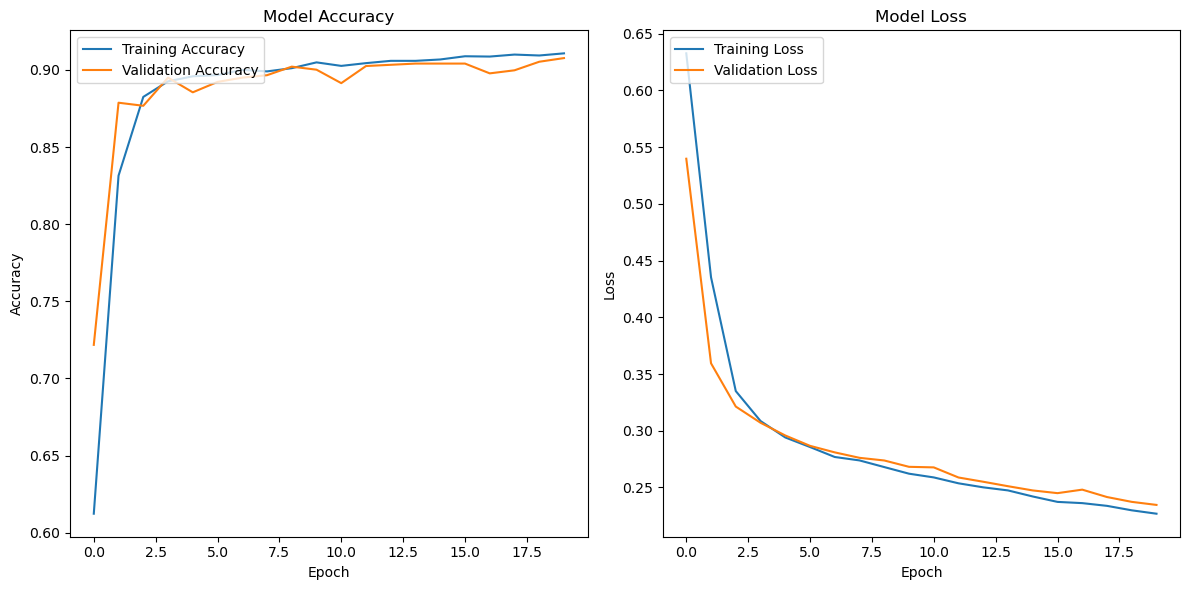

In [17]:
import matplotlib.pyplot as plt



def plot_accuracy_loss(hist):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_accuracy_loss(hist)


79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.8716 - loss: 0.2516
Test Loss: 0.2346467673778534
Test Accuracy: 0.9076496362686157
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 213ms/step
Confusion Matrix:
[[1313  185]
 [  48  977]]


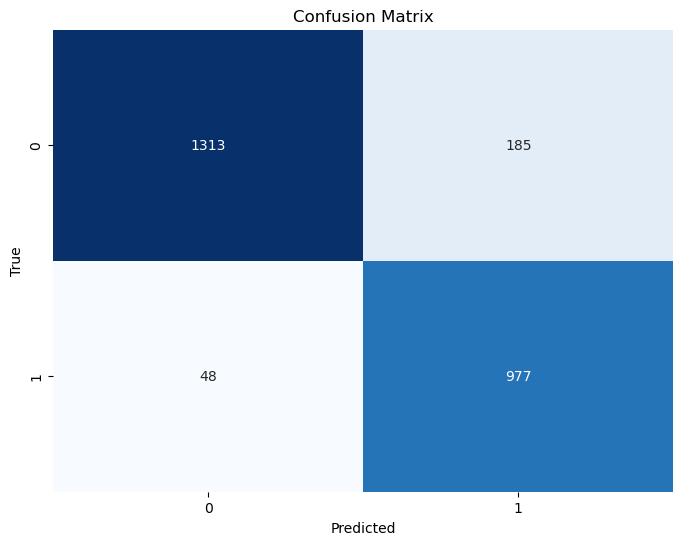

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1498
           1       0.84      0.95      0.89      1025

    accuracy                           0.91      2523
   macro avg       0.90      0.91      0.91      2523
weighted avg       0.91      0.91      0.91      2523



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


def evaluate_model(model, test_data, test_labels):
    loss, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

    predictions = np.argmax(model.predict(test_data), axis=1)  

    if test_labels.ndim > 1 and test_labels.shape[1] > 1: 
        test_labels = np.argmax(test_labels, axis=1)

    cm = confusion_matrix(test_labels, predictions)
    print("Confusion Matrix:")
    print(cm)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


    report = classification_report(test_labels, predictions)
    print("Classification Report:")
    print(report)


evaluate_model(model, X_test, Y_test)


In [28]:
sample = X_test[0:1]  
predictions = np.argmax(model.predict(sample), axis=1)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[0]


In [42]:
X_test[0].shape

(128, 128, 3)

In [43]:
img_array.shape

(256, 384, 3)

In [30]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


image_path = r"D:\project\image_forging\Casia_database\Tp_Test\Tp_D_CNN_M_N_sec10110_sec10101_10298.tif"
img = Image.open(image_path)


img = img.resize((128, 128))  


img_array = np.array(img) / 255.0  


if img_array.shape[-1] != 3:
    raise ValueError("The input image must have 3 channels (RGB).")


img_array = np.expand_dims(img_array, axis=0)


predictions = model.predict(img_array)


predicted_label = np.argmax(predictions, axis=1)


print("Image Forging predictiona are",predictions[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image Forging predictiona are [1.000000e+00 3.922798e-32]


In [34]:
predictions[0][0], predicted_label

(1.0, array([0], dtype=int64))

In [8]:

save_model(model, "image_forging_detection.h5")

In [11]:
from tensorflow import keras
keras.models.save_model(model, 'my_model.keras')

In [2]:
from tensorflow import keras

from keras.models import load_model
model = keras.models.load_model("image_forging_detection.h5")

In [3]:
class_names = ['Forged', 'Authentic']

In [17]:
from tqdm import tqdm  

correct_test = 0  
total_test = 0    

for index, image in enumerate(tqdm(X_test, desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    y_pred_class = np.round(y_pred)
    total_test += 1
    if y_pred_class[0][0] == Y_test[index][0]:  
        correct_test += 1
    
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {correct_test / total_test * 100.0} %')


Processing Images :   0%|                                                                     | 0/2523 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :   0%|                                                             | 2/2523 [00:00<03:51, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :   0%|                                                             | 4/2523 [00:00<04:17,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :   0%|▏                                                            | 6/2523 [00:00<03:53, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :   0%|▏                                                            | 8/2523 [00:00<03:52, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :   0%|▏                                                           | 10/2523 [00:00<03:48, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images :   0%|▎                                                           | 12/2523 [00:01<04:11,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images :   1%|▎                                                           | 14/2523 [00:01<04:39,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :   1%|▎                                                           | 15/2523 [00:01<04:38,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :   1%|▍                                                           | 17/2523 [00:01<04:19,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images :   1%|▍                                                           | 19/2523 [00:01<04:30,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :   1%|▍                                                           | 20/2523 [00:02<04:41,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :   1%|▍                                                           | 21/2523 [00:02<04:39,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :   1%|▌                                                           | 22/2523 [00:02<04:35,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :   1%|▌                                                           | 23/2523 [00:02<04:39,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :   1%|▌                                                           | 24/2523 [00:02<04:45,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :   1%|▌                                                           | 25/2523 [00:02<04:46,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :   1%|▌                                                           | 26/2523 [00:02<04:48,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :   1%|▋                                                           | 27/2523 [00:02<04:38,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :   1%|▋                                                           | 28/2523 [00:02<04:34,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :   1%|▋                                                           | 29/2523 [00:03<04:30,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :   1%|▋                                                           | 30/2523 [00:03<04:34,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :   1%|▋                                                           | 31/2523 [00:03<04:37,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :   1%|▊                                                           | 32/2523 [00:03<04:32,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :   1%|▊                                                           | 34/2523 [00:03<04:12,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :   1%|▊                                                           | 36/2523 [00:03<04:01, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :   2%|▉                                                           | 38/2523 [00:03<03:54, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :   2%|▉                                                           | 40/2523 [00:04<04:00, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :   2%|▉                                                           | 42/2523 [00:04<03:52, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :   2%|█                                                           | 44/2523 [00:04<03:55, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :   2%|█                                                           | 46/2523 [00:04<03:48, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :   2%|█▏                                                          | 48/2523 [00:04<03:44, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :   2%|█▏                                                          | 50/2523 [00:05<03:40, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :   2%|█▏                                                          | 52/2523 [00:05<03:41, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :   2%|█▎                                                          | 54/2523 [00:05<03:56, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :   2%|█▎                                                          | 56/2523 [00:05<03:54, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :   2%|█▍                                                          | 58/2523 [00:05<03:47, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   2%|█▍                                                          | 60/2523 [00:05<03:44, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :   2%|█▍                                                          | 62/2523 [00:06<03:59, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :   3%|█▌                                                          | 64/2523 [00:06<04:11,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :   3%|█▌                                                          | 65/2523 [00:06<04:14,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :   3%|█▌                                                          | 66/2523 [00:06<04:16,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :   3%|█▌                                                          | 68/2523 [00:06<04:02, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :   3%|█▋                                                          | 70/2523 [00:07<03:56, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :   3%|█▋                                                          | 72/2523 [00:07<03:55, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :   3%|█▊                                                          | 74/2523 [00:07<03:45, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :   3%|█▊                                                          | 76/2523 [00:07<03:42, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :   3%|█▊                                                          | 78/2523 [00:07<03:43, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :   3%|█▉                                                          | 80/2523 [00:07<03:36, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :   3%|█▉                                                          | 82/2523 [00:08<03:35, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :   3%|█▉                                                          | 84/2523 [00:08<03:50, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :   3%|██                                                          | 86/2523 [00:08<03:46, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :   3%|██                                                          | 88/2523 [00:08<03:46, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   4%|██▏                                                         | 90/2523 [00:08<03:41, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :   4%|██▏                                                         | 92/2523 [00:09<03:45, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   4%|██▏                                                         | 94/2523 [00:09<03:37, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :   4%|██▎                                                         | 96/2523 [00:09<03:34, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :   4%|██▎                                                         | 98/2523 [00:09<03:33, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :   4%|██▎                                                        | 100/2523 [00:09<03:28, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :   4%|██▍                                                        | 102/2523 [00:09<03:23, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :   4%|██▍                                                        | 104/2523 [00:10<03:29, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :   4%|██▍                                                        | 106/2523 [00:10<03:37, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :   4%|██▌                                                        | 108/2523 [00:10<03:39, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :   4%|██▌                                                        | 110/2523 [00:10<03:56, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :   4%|██▌                                                        | 112/2523 [00:10<03:49, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :   5%|██▋                                                        | 114/2523 [00:11<04:08,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :   5%|██▋                                                        | 115/2523 [00:11<04:18,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :   5%|██▋                                                        | 116/2523 [00:11<04:29,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :   5%|██▋                                                        | 117/2523 [00:11<04:28,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   5%|██▊                                                        | 119/2523 [00:11<04:07,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :   5%|██▊                                                        | 121/2523 [00:11<03:49, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :   5%|██▉                                                        | 123/2523 [00:12<04:09,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :   5%|██▉                                                        | 125/2523 [00:12<04:05,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :   5%|██▉                                                        | 127/2523 [00:12<03:57, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   5%|███                                                        | 129/2523 [00:12<03:47, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images :   5%|███                                                        | 131/2523 [00:12<04:16,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images :   5%|███                                                        | 132/2523 [00:13<04:32,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images :   5%|███                                                        | 133/2523 [00:13<04:48,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images :   5%|███▏                                                       | 134/2523 [00:13<04:58,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :   5%|███▏                                                       | 135/2523 [00:13<05:06,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Images :   5%|███▏                                                       | 136/2523 [00:13<05:21,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :   5%|███▏                                                       | 137/2523 [00:13<05:32,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :   5%|███▏                                                       | 138/2523 [00:13<05:31,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Images :   6%|███▎                                                       | 139/2523 [00:14<06:34,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :   6%|███▎                                                       | 140/2523 [00:14<05:58,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :   6%|███▎                                                       | 142/2523 [00:14<05:03,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :   6%|███▎                                                       | 143/2523 [00:14<04:48,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :   6%|███▎                                                       | 144/2523 [00:14<04:49,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   6%|███▍                                                       | 146/2523 [00:14<04:12,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :   6%|███▍                                                       | 148/2523 [00:15<04:16,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :   6%|███▍                                                       | 149/2523 [00:15<04:24,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :   6%|███▌                                                       | 150/2523 [00:15<04:28,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :   6%|███▌                                                       | 151/2523 [00:15<04:31,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :   6%|███▌                                                       | 152/2523 [00:15<04:38,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :   6%|███▌                                                       | 154/2523 [00:15<04:07,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :   6%|███▌                                                       | 155/2523 [00:15<04:06,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :   6%|███▋                                                       | 157/2523 [00:15<03:53, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :   6%|███▋                                                       | 159/2523 [00:16<03:48, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :   6%|███▊                                                       | 161/2523 [00:16<03:40, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :   6%|███▊                                                       | 163/2523 [00:16<03:40, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :   7%|███▊                                                       | 165/2523 [00:16<03:48, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :   7%|███▉                                                       | 167/2523 [00:16<03:40, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :   7%|███▉                                                       | 169/2523 [00:17<03:51, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :   7%|███▉                                                       | 171/2523 [00:17<03:51, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :   7%|████                                                       | 173/2523 [00:17<03:53, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :   7%|████                                                       | 175/2523 [00:17<03:42, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :   7%|████▏                                                      | 177/2523 [00:17<03:59,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :   7%|████▏                                                      | 178/2523 [00:18<04:11,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :   7%|████▏                                                      | 179/2523 [00:18<04:23,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :   7%|████▏                                                      | 180/2523 [00:18<04:34,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Images :   7%|████▏                                                      | 181/2523 [00:18<05:13,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :   7%|████▎                                                      | 182/2523 [00:18<05:06,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :   7%|████▎                                                      | 183/2523 [00:18<05:03,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :   7%|████▎                                                      | 184/2523 [00:18<05:01,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :   7%|████▎                                                      | 185/2523 [00:19<05:07,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :   7%|████▎                                                      | 186/2523 [00:19<05:02,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :   7%|████▎                                                      | 187/2523 [00:19<04:51,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :   7%|████▍                                                      | 188/2523 [00:19<04:49,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :   7%|████▍                                                      | 189/2523 [00:19<04:52,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :   8%|████▍                                                      | 190/2523 [00:19<04:40,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :   8%|████▍                                                      | 192/2523 [00:19<04:22,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :   8%|████▌                                                      | 193/2523 [00:19<04:16,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :   8%|████▌                                                      | 194/2523 [00:20<04:10,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :   8%|████▌                                                      | 196/2523 [00:20<03:50, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :   8%|████▋                                                      | 198/2523 [00:20<03:56,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images :   8%|████▋                                                      | 199/2523 [00:20<04:10,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images :   8%|████▋                                                      | 200/2523 [00:20<04:30,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :   8%|████▋                                                      | 201/2523 [00:20<04:29,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :   8%|████▋                                                      | 202/2523 [00:20<04:21,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :   8%|████▋                                                      | 203/2523 [00:21<04:21,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :   8%|████▊                                                      | 205/2523 [00:21<04:06,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :   8%|████▊                                                      | 207/2523 [00:21<03:53,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :   8%|████▉                                                      | 209/2523 [00:21<03:44, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :   8%|████▉                                                      | 211/2523 [00:21<03:56,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :   8%|████▉                                                      | 212/2523 [00:21<03:58,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   8%|████▉                                                      | 213/2523 [00:22<04:00,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :   9%|█████                                                      | 215/2523 [00:22<03:53,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :   9%|█████                                                      | 217/2523 [00:22<03:41, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :   9%|█████                                                      | 219/2523 [00:22<03:34, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :   9%|█████▏                                                     | 221/2523 [00:22<03:39, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :   9%|█████▏                                                     | 223/2523 [00:22<03:39, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :   9%|█████▎                                                     | 225/2523 [00:23<03:38, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :   9%|█████▎                                                     | 227/2523 [00:23<03:54,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :   9%|█████▎                                                     | 229/2523 [00:23<03:49,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :   9%|█████▍                                                     | 231/2523 [00:23<03:40, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :   9%|█████▍                                                     | 233/2523 [00:23<03:33, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :   9%|█████▍                                                     | 235/2523 [00:24<03:32, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   9%|█████▌                                                     | 237/2523 [00:24<03:22, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :   9%|█████▌                                                     | 239/2523 [00:24<03:25, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  10%|█████▋                                                     | 241/2523 [00:24<03:20, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :  10%|█████▋                                                     | 243/2523 [00:24<03:26, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  10%|█████▋                                                     | 245/2523 [00:25<03:50,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  10%|█████▊                                                     | 247/2523 [00:25<03:59,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  10%|█████▊                                                     | 248/2523 [00:25<03:58,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  10%|█████▊                                                     | 250/2523 [00:25<03:45, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  10%|█████▉                                                     | 252/2523 [00:25<03:42, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  10%|█████▉                                                     | 254/2523 [00:25<03:39, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  10%|█████▉                                                     | 256/2523 [00:26<03:27, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  10%|██████                                                     | 258/2523 [00:26<03:30, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  10%|██████                                                     | 260/2523 [00:26<03:35, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  10%|██████▏                                                    | 262/2523 [00:26<03:39, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  10%|██████▏                                                    | 264/2523 [00:26<03:38, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  11%|██████▏                                                    | 266/2523 [00:27<03:38, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  11%|██████▎                                                    | 268/2523 [00:27<03:36, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  11%|██████▎                                                    | 270/2523 [00:27<03:32, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  11%|██████▎                                                    | 272/2523 [00:27<03:50,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images :  11%|██████▍                                                    | 273/2523 [00:27<04:08,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Images :  11%|██████▍                                                    | 274/2523 [00:28<04:43,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  11%|██████▍                                                    | 275/2523 [00:28<04:49,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  11%|██████▍                                                    | 276/2523 [00:28<04:51,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  11%|██████▍                                                    | 277/2523 [00:28<04:41,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  11%|██████▌                                                    | 278/2523 [00:28<04:38,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  11%|██████▌                                                    | 279/2523 [00:28<04:29,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  11%|██████▌                                                    | 280/2523 [00:28<04:24,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  11%|██████▌                                                    | 281/2523 [00:28<04:18,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  11%|██████▌                                                    | 282/2523 [00:28<04:17,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  11%|██████▌                                                    | 283/2523 [00:29<04:16,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  11%|██████▋                                                    | 284/2523 [00:29<04:19,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  11%|██████▋                                                    | 285/2523 [00:29<04:20,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  11%|██████▋                                                    | 286/2523 [00:29<04:19,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  11%|██████▋                                                    | 287/2523 [00:29<04:17,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  11%|██████▋                                                    | 288/2523 [00:29<04:15,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  11%|██████▊                                                    | 289/2523 [00:29<04:09,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  11%|██████▊                                                    | 290/2523 [00:29<04:07,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  12%|██████▊                                                    | 291/2523 [00:30<04:16,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  12%|██████▊                                                    | 293/2523 [00:30<04:02,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  12%|██████▉                                                    | 294/2523 [00:30<04:07,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  12%|██████▉                                                    | 295/2523 [00:30<04:09,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  12%|██████▉                                                    | 296/2523 [00:30<04:19,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  12%|██████▉                                                    | 298/2523 [00:30<04:06,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  12%|██████▉                                                    | 299/2523 [00:30<04:02,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  12%|███████                                                    | 300/2523 [00:30<03:59,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  12%|███████                                                    | 302/2523 [00:31<03:47,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  12%|███████                                                    | 304/2523 [00:31<03:44,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  12%|███████▏                                                   | 305/2523 [00:31<03:47,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  12%|███████▏                                                   | 306/2523 [00:31<03:47,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  12%|███████▏                                                   | 308/2523 [00:31<03:44,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  12%|███████▏                                                   | 310/2523 [00:31<03:44,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  12%|███████▎                                                   | 311/2523 [00:32<03:48,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  12%|███████▎                                                   | 313/2523 [00:32<03:34, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  12%|███████▎                                                   | 315/2523 [00:32<03:23, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  13%|███████▍                                                   | 317/2523 [00:32<03:23, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  13%|███████▍                                                   | 319/2523 [00:32<03:13, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  13%|███████▌                                                   | 321/2523 [00:32<03:10, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  13%|███████▌                                                   | 323/2523 [00:33<03:04, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  13%|███████▌                                                   | 325/2523 [00:33<03:08, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  13%|███████▋                                                   | 327/2523 [00:33<03:03, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  13%|███████▋                                                   | 329/2523 [00:33<03:32, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  13%|███████▋                                                   | 331/2523 [00:33<03:32, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  13%|███████▊                                                   | 333/2523 [00:34<03:20, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  13%|███████▊                                                   | 335/2523 [00:34<03:11, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  13%|███████▉                                                   | 337/2523 [00:34<03:10, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  13%|███████▉                                                   | 339/2523 [00:34<03:19, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  14%|███████▉                                                   | 341/2523 [00:34<03:34, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  14%|████████                                                   | 343/2523 [00:34<03:29, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  14%|████████                                                   | 345/2523 [00:35<03:22, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  14%|████████                                                   | 347/2523 [00:35<03:32, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  14%|████████▏                                                  | 349/2523 [00:35<03:36, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  14%|████████▏                                                  | 351/2523 [00:35<03:37, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  14%|████████▎                                                  | 353/2523 [00:36<03:40,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  14%|████████▎                                                  | 354/2523 [00:36<03:41,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  14%|████████▎                                                  | 356/2523 [00:36<03:36,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  14%|████████▎                                                  | 357/2523 [00:36<03:36,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  14%|████████▎                                                  | 358/2523 [00:36<03:38,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  14%|████████▍                                                  | 359/2523 [00:36<03:38,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  14%|████████▍                                                  | 361/2523 [00:36<03:36,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  14%|████████▍                                                  | 362/2523 [00:36<03:45,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  14%|████████▍                                                  | 363/2523 [00:37<03:48,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  14%|████████▌                                                  | 364/2523 [00:37<03:48,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  14%|████████▌                                                  | 365/2523 [00:37<03:47,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  15%|████████▌                                                  | 367/2523 [00:37<03:33, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  15%|████████▋                                                  | 369/2523 [00:37<03:31, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  15%|████████▋                                                  | 371/2523 [00:37<03:31, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  15%|████████▋                                                  | 373/2523 [00:38<03:28, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images :  15%|████████▊                                                  | 375/2523 [00:38<03:19, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  15%|████████▊                                                  | 377/2523 [00:38<03:25, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images :  15%|████████▊                                                  | 379/2523 [00:38<03:53,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  15%|████████▉                                                  | 380/2523 [00:38<03:56,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  15%|████████▉                                                  | 381/2523 [00:38<03:52,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  15%|████████▉                                                  | 382/2523 [00:38<03:49,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  15%|████████▉                                                  | 384/2523 [00:39<03:39,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  15%|█████████                                                  | 385/2523 [00:39<03:46,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  15%|█████████                                                  | 386/2523 [00:39<03:53,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  15%|█████████                                                  | 387/2523 [00:39<03:48,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  15%|█████████                                                  | 389/2523 [00:39<03:43,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  15%|█████████                                                  | 390/2523 [00:39<03:52,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  15%|█████████▏                                                 | 391/2523 [00:39<04:03,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  16%|█████████▏                                                 | 392/2523 [00:40<04:00,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  16%|█████████▏                                                 | 393/2523 [00:40<03:54,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  16%|█████████▏                                                 | 395/2523 [00:40<03:35,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  16%|█████████▎                                                 | 397/2523 [00:40<03:22, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  16%|█████████▎                                                 | 399/2523 [00:40<03:15, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  16%|█████████▍                                                 | 401/2523 [00:40<03:18, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  16%|█████████▍                                                 | 403/2523 [00:41<03:15, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  16%|█████████▍                                                 | 405/2523 [00:41<03:08, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images :  16%|█████████▌                                                 | 407/2523 [00:41<03:08, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images :  16%|█████████▌                                                 | 409/2523 [00:41<03:04, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  16%|█████████▌                                                 | 411/2523 [00:41<03:09, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  16%|█████████▋                                                 | 413/2523 [00:41<03:14, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  16%|█████████▋                                                 | 415/2523 [00:42<03:14, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  17%|█████████▊                                                 | 417/2523 [00:42<03:15, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images :  17%|█████████▊                                                 | 419/2523 [00:42<03:29, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  17%|█████████▊                                                 | 421/2523 [00:42<03:40,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  17%|█████████▊                                                 | 422/2523 [00:42<03:40,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  17%|█████████▉                                                 | 423/2523 [00:43<03:43,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  17%|█████████▉                                                 | 425/2523 [00:43<03:39,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  17%|█████████▉                                                 | 427/2523 [00:43<03:27, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  17%|██████████                                                 | 429/2523 [00:43<03:19, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  17%|██████████                                                 | 431/2523 [00:43<03:18, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  17%|██████████▏                                                | 433/2523 [00:43<03:25, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  17%|██████████▏                                                | 435/2523 [00:44<03:26, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  17%|██████████▏                                                | 437/2523 [00:44<03:35,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  17%|██████████▏                                                | 438/2523 [00:44<03:38,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  17%|██████████▎                                                | 439/2523 [00:44<03:39,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  17%|██████████▎                                                | 440/2523 [00:44<03:38,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  17%|██████████▎                                                | 441/2523 [00:44<03:42,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  18%|██████████▎                                                | 442/2523 [00:44<03:50,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  18%|██████████▎                                                | 443/2523 [00:45<03:54,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  18%|██████████▍                                                | 444/2523 [00:45<03:55,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  18%|██████████▍                                                | 445/2523 [00:45<03:55,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  18%|██████████▍                                                | 446/2523 [00:45<03:47,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  18%|██████████▍                                                | 448/2523 [00:45<03:33,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  18%|██████████▍                                                | 449/2523 [00:45<03:42,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  18%|██████████▌                                                | 450/2523 [00:45<03:40,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  18%|██████████▌                                                | 452/2523 [00:46<03:35,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  18%|██████████▌                                                | 453/2523 [00:46<03:42,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  18%|██████████▌                                                | 454/2523 [00:46<03:38,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  18%|██████████▋                                                | 456/2523 [00:46<03:21, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  18%|██████████▋                                                | 458/2523 [00:46<03:22, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  18%|██████████▊                                                | 460/2523 [00:46<03:28,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  18%|██████████▊                                                | 461/2523 [00:46<03:29,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  18%|██████████▊                                                | 462/2523 [00:47<03:29,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  18%|██████████▊                                                | 463/2523 [00:47<03:29,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  18%|██████████▊                                                | 464/2523 [00:47<03:39,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  18%|██████████▉                                                | 466/2523 [00:47<03:28,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  19%|██████████▉                                                | 468/2523 [00:47<03:25,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  19%|██████████▉                                                | 470/2523 [00:47<03:24, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  19%|███████████                                                | 472/2523 [00:48<03:20, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  19%|███████████                                                | 474/2523 [00:48<03:14, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  19%|███████████▏                                               | 476/2523 [00:48<03:11, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  19%|███████████▏                                               | 478/2523 [00:48<03:05, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  19%|███████████▏                                               | 480/2523 [00:48<03:00, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  19%|███████████▎                                               | 482/2523 [00:48<03:05, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  19%|███████████▎                                               | 484/2523 [00:49<03:17, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  19%|███████████▎                                               | 486/2523 [00:49<03:25,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  19%|███████████▍                                               | 488/2523 [00:49<03:14, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  19%|███████████▍                                               | 490/2523 [00:49<03:15, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  20%|███████████▌                                               | 492/2523 [00:49<03:16, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  20%|███████████▌                                               | 494/2523 [00:50<03:52,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  20%|███████████▌                                               | 495/2523 [00:50<03:55,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  20%|███████████▌                                               | 496/2523 [00:50<03:59,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  20%|███████████▌                                               | 497/2523 [00:50<03:52,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  20%|███████████▋                                               | 499/2523 [00:50<03:31,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  20%|███████████▋                                               | 501/2523 [00:50<03:21, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  20%|███████████▊                                               | 503/2523 [00:51<03:21, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  20%|███████████▊                                               | 505/2523 [00:51<03:17, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  20%|███████████▊                                               | 507/2523 [00:51<03:23,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  20%|███████████▉                                               | 508/2523 [00:51<03:27,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  20%|███████████▉                                               | 509/2523 [00:51<03:36,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  20%|███████████▉                                               | 511/2523 [00:51<03:27,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  20%|███████████▉                                               | 513/2523 [00:52<03:19, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  20%|████████████                                               | 515/2523 [00:52<03:19, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  20%|████████████                                               | 516/2523 [00:52<03:21,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  20%|████████████                                               | 517/2523 [00:52<03:28,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  21%|████████████                                               | 518/2523 [00:52<03:35,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  21%|████████████▏                                              | 519/2523 [00:52<03:36,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  21%|████████████▏                                              | 520/2523 [00:52<03:42,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  21%|████████████▏                                              | 521/2523 [00:53<03:57,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  21%|████████████▏                                              | 522/2523 [00:53<04:03,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  21%|████████████▏                                              | 523/2523 [00:53<03:56,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  21%|████████████▎                                              | 525/2523 [00:53<03:34,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  21%|████████████▎                                              | 527/2523 [00:53<03:25,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Processing Images :  21%|████████████▎                                              | 528/2523 [00:53<03:59,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images :  21%|████████████▎                                              | 529/2523 [00:54<04:42,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  21%|████████████▍                                              | 530/2523 [00:54<04:35,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  21%|████████████▍                                              | 531/2523 [00:54<04:32,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  21%|████████████▍                                              | 532/2523 [00:54<04:26,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  21%|████████████▍                                              | 533/2523 [00:54<04:20,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  21%|████████████▍                                              | 534/2523 [00:54<04:17,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  21%|████████████▌                                              | 535/2523 [00:54<04:11,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  21%|████████████▌                                              | 536/2523 [00:54<04:09,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  21%|████████████▌                                              | 537/2523 [00:55<04:04,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  21%|████████████▌                                              | 538/2523 [00:55<04:06,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  21%|████████████▌                                              | 539/2523 [00:55<04:01,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  21%|████████████▋                                              | 540/2523 [00:55<04:03,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  21%|████████████▋                                              | 541/2523 [00:55<04:01,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  21%|████████████▋                                              | 542/2523 [00:55<04:01,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  22%|████████████▋                                              | 543/2523 [00:55<04:01,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  22%|████████████▋                                              | 544/2523 [00:55<04:01,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  22%|████████████▋                                              | 545/2523 [00:56<04:04,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  22%|████████████▊                                              | 546/2523 [00:56<04:05,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  22%|████████████▊                                              | 547/2523 [00:56<04:08,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  22%|████████████▊                                              | 548/2523 [00:56<04:13,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images :  22%|████████████▊                                              | 549/2523 [00:56<04:22,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  22%|████████████▊                                              | 550/2523 [00:56<04:26,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  22%|████████████▉                                              | 551/2523 [00:56<04:28,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images :  22%|████████████▉                                              | 552/2523 [00:57<04:29,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images :  22%|████████████▉                                              | 553/2523 [00:57<04:34,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images :  22%|████████████▉                                              | 554/2523 [00:57<04:39,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images :  22%|████████████▉                                              | 555/2523 [00:57<04:45,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  22%|█████████████                                              | 556/2523 [00:57<04:32,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  22%|█████████████                                              | 557/2523 [00:57<04:32,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images :  22%|█████████████                                              | 558/2523 [00:58<07:25,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images :  22%|█████████████                                              | 559/2523 [00:58<06:36,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images :  22%|█████████████                                              | 560/2523 [00:58<06:09,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images :  22%|█████████████                                              | 561/2523 [00:58<05:43,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  22%|█████████████▏                                             | 562/2523 [00:58<05:22,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  22%|█████████████▏                                             | 563/2523 [00:58<05:01,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  22%|█████████████▏                                             | 564/2523 [00:58<04:40,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  22%|█████████████▏                                             | 565/2523 [00:59<04:15,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  22%|█████████████▎                                             | 567/2523 [00:59<03:41,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images :  23%|█████████████▎                                             | 569/2523 [00:59<03:44,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images :  23%|█████████████▎                                             | 570/2523 [00:59<03:57,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images :  23%|█████████████▎                                             | 571/2523 [00:59<04:06,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  23%|█████████████▍                                             | 572/2523 [00:59<04:10,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  23%|█████████████▍                                             | 573/2523 [01:00<04:03,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  23%|█████████████▍                                             | 574/2523 [01:00<03:54,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  23%|█████████████▍                                             | 575/2523 [01:00<03:47,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  23%|█████████████▍                                             | 576/2523 [01:00<03:40,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  23%|█████████████▍                                             | 577/2523 [01:00<03:35,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  23%|█████████████▌                                             | 578/2523 [01:00<03:36,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  23%|█████████████▌                                             | 579/2523 [01:00<03:41,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  23%|█████████████▌                                             | 580/2523 [01:00<03:36,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :  23%|█████████████▌                                             | 581/2523 [01:00<03:56,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  23%|█████████████▌                                             | 582/2523 [01:01<03:54,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  23%|█████████████▋                                             | 583/2523 [01:01<03:43,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  23%|█████████████▋                                             | 584/2523 [01:01<03:35,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  23%|█████████████▋                                             | 585/2523 [01:01<03:34,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  23%|█████████████▋                                             | 586/2523 [01:01<03:33,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  23%|█████████████▊                                             | 588/2523 [01:01<03:22,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  23%|█████████████▊                                             | 589/2523 [01:01<03:25,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  23%|█████████████▊                                             | 590/2523 [01:01<03:34,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  23%|█████████████▊                                             | 591/2523 [01:02<03:56,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  23%|█████████████▊                                             | 592/2523 [01:02<03:57,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  24%|█████████████▊                                             | 593/2523 [01:02<03:47,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  24%|█████████████▉                                             | 594/2523 [01:02<03:41,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  24%|█████████████▉                                             | 596/2523 [01:02<03:15,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  24%|█████████████▉                                             | 597/2523 [01:02<03:15,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  24%|█████████████▉                                             | 598/2523 [01:02<03:23,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  24%|██████████████                                             | 599/2523 [01:02<03:21,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  24%|██████████████                                             | 600/2523 [01:02<03:20,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  24%|██████████████                                             | 602/2523 [01:03<03:06, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  24%|██████████████                                             | 604/2523 [01:03<02:59, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  24%|██████████████▏                                            | 606/2523 [01:03<03:06, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  24%|██████████████▏                                            | 608/2523 [01:03<02:59, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  24%|██████████████▎                                            | 610/2523 [01:03<02:56, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  24%|██████████████▎                                            | 612/2523 [01:04<02:59, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  24%|██████████████▎                                            | 614/2523 [01:04<02:52, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  24%|██████████████▍                                            | 616/2523 [01:04<03:05, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  24%|██████████████▍                                            | 618/2523 [01:04<03:05, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  25%|██████████████▍                                            | 620/2523 [01:04<03:04, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  25%|██████████████▌                                            | 622/2523 [01:05<03:04, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  25%|██████████████▌                                            | 624/2523 [01:05<03:05, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  25%|██████████████▋                                            | 626/2523 [01:05<02:59, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images :  25%|██████████████▋                                            | 628/2523 [01:05<02:56, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images :  25%|██████████████▋                                            | 630/2523 [01:05<02:53, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  25%|██████████████▊                                            | 632/2523 [01:05<02:53, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images :  25%|██████████████▊                                            | 634/2523 [01:06<02:52, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  25%|██████████████▊                                            | 636/2523 [01:06<02:49, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  25%|██████████████▉                                            | 638/2523 [01:06<02:47, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  25%|██████████████▉                                            | 640/2523 [01:06<02:49, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  25%|███████████████                                            | 642/2523 [01:06<02:53, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  26%|███████████████                                            | 644/2523 [01:07<02:53, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  26%|███████████████                                            | 646/2523 [01:07<02:49, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  26%|███████████████▏                                           | 648/2523 [01:07<02:47, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  26%|███████████████▏                                           | 650/2523 [01:07<02:44, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  26%|███████████████▏                                           | 652/2523 [01:07<03:00, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  26%|███████████████▎                                           | 654/2523 [01:08<03:00, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  26%|███████████████▎                                           | 656/2523 [01:08<02:58, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  26%|███████████████▍                                           | 658/2523 [01:08<02:56, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  26%|███████████████▍                                           | 660/2523 [01:08<02:59, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  26%|███████████████▍                                           | 662/2523 [01:08<02:54, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  26%|███████████████▌                                           | 664/2523 [01:08<02:52, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  26%|███████████████▌                                           | 666/2523 [01:09<02:52, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  26%|███████████████▌                                           | 668/2523 [01:09<02:52, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  27%|███████████████▋                                           | 670/2523 [01:09<02:54, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  27%|███████████████▋                                           | 672/2523 [01:09<02:51, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  27%|███████████████▊                                           | 674/2523 [01:09<02:52, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  27%|███████████████▊                                           | 676/2523 [01:10<02:46, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images :  27%|███████████████▊                                           | 678/2523 [01:10<02:43, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  27%|███████████████▉                                           | 680/2523 [01:10<02:43, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  27%|███████████████▉                                           | 682/2523 [01:10<02:49, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  27%|███████████████▉                                           | 684/2523 [01:10<03:02, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  27%|████████████████                                           | 686/2523 [01:11<03:08,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  27%|████████████████                                           | 687/2523 [01:11<03:18,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  27%|████████████████                                           | 688/2523 [01:11<03:18,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  27%|████████████████                                           | 689/2523 [01:11<03:18,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  27%|████████████████▏                                          | 691/2523 [01:11<03:11,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  27%|████████████████▏                                          | 692/2523 [01:11<03:09,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  27%|████████████████▏                                          | 693/2523 [01:11<03:08,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  28%|████████████████▎                                          | 695/2523 [01:11<03:05,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  28%|████████████████▎                                          | 697/2523 [01:12<02:57, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  28%|████████████████▎                                          | 699/2523 [01:12<02:53, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  28%|████████████████▍                                          | 701/2523 [01:12<02:47, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  28%|████████████████▍                                          | 703/2523 [01:12<02:48, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  28%|████████████████▍                                          | 705/2523 [01:12<02:47, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  28%|████████████████▌                                          | 707/2523 [01:13<02:47, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  28%|████████████████▌                                          | 709/2523 [01:13<02:52, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  28%|████████████████▋                                          | 711/2523 [01:13<02:52, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  28%|████████████████▋                                          | 713/2523 [01:13<02:48, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  28%|████████████████▋                                          | 715/2523 [01:13<02:49, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  28%|████████████████▊                                          | 717/2523 [01:14<02:59, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  28%|████████████████▊                                          | 719/2523 [01:14<02:53, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  29%|████████████████▊                                          | 721/2523 [01:14<02:52, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  29%|████████████████▉                                          | 723/2523 [01:14<02:48, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images :  29%|████████████████▉                                          | 725/2523 [01:14<02:45, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  29%|█████████████████                                          | 727/2523 [01:14<02:47, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  29%|█████████████████                                          | 729/2523 [01:15<02:45, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  29%|█████████████████                                          | 731/2523 [01:15<02:40, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  29%|█████████████████▏                                         | 733/2523 [01:15<02:43, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  29%|█████████████████▏                                         | 735/2523 [01:15<02:45, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  29%|█████████████████▏                                         | 737/2523 [01:15<02:50, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  29%|█████████████████▎                                         | 739/2523 [01:16<02:51, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  29%|█████████████████▎                                         | 741/2523 [01:16<02:54, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  29%|█████████████████▎                                         | 743/2523 [01:16<03:08,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  30%|█████████████████▍                                         | 745/2523 [01:16<03:02,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  30%|█████████████████▍                                         | 747/2523 [01:16<03:04,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  30%|█████████████████▌                                         | 749/2523 [01:17<03:01,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  30%|█████████████████▌                                         | 751/2523 [01:17<02:57,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  30%|█████████████████▌                                         | 753/2523 [01:17<02:58,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  30%|█████████████████▋                                         | 754/2523 [01:17<02:59,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  30%|█████████████████▋                                         | 755/2523 [01:17<03:05,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  30%|█████████████████▋                                         | 756/2523 [01:17<03:06,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  30%|█████████████████▋                                         | 757/2523 [01:17<03:04,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  30%|█████████████████▋                                         | 758/2523 [01:18<03:05,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  30%|█████████████████▋                                         | 759/2523 [01:18<03:07,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  30%|█████████████████▊                                         | 761/2523 [01:18<02:56,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  30%|█████████████████▊                                         | 763/2523 [01:18<02:50, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  30%|█████████████████▉                                         | 765/2523 [01:18<02:51, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  30%|█████████████████▉                                         | 767/2523 [01:18<02:49, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  30%|█████████████████▉                                         | 769/2523 [01:19<02:47, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  31%|██████████████████                                         | 771/2523 [01:19<02:45, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  31%|██████████████████                                         | 773/2523 [01:19<02:54, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  31%|██████████████████                                         | 775/2523 [01:19<02:52, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  31%|██████████████████▏                                        | 777/2523 [01:19<02:47, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  31%|██████████████████▏                                        | 779/2523 [01:20<02:48, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  31%|██████████████████▎                                        | 781/2523 [01:20<02:43, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  31%|██████████████████▎                                        | 783/2523 [01:20<02:37, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images :  31%|██████████████████▎                                        | 785/2523 [01:20<02:35, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images :  31%|██████████████████▍                                        | 787/2523 [01:20<02:32, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  31%|██████████████████▍                                        | 789/2523 [01:20<02:34, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  31%|██████████████████▍                                        | 791/2523 [01:21<02:36, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  31%|██████████████████▌                                        | 793/2523 [01:21<02:37, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  32%|██████████████████▌                                        | 795/2523 [01:21<02:39, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  32%|██████████████████▋                                        | 797/2523 [01:21<02:41, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  32%|██████████████████▋                                        | 799/2523 [01:21<02:37, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  32%|██████████████████▋                                        | 801/2523 [01:22<02:38, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  32%|██████████████████▊                                        | 803/2523 [01:22<02:33, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  32%|██████████████████▊                                        | 805/2523 [01:22<02:30, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  32%|██████████████████▊                                        | 807/2523 [01:22<02:45, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  32%|██████████████████▉                                        | 809/2523 [01:22<02:42, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  32%|██████████████████▉                                        | 811/2523 [01:23<02:42, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  32%|███████████████████                                        | 813/2523 [01:23<02:38, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  32%|███████████████████                                        | 815/2523 [01:23<02:38, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  32%|███████████████████                                        | 817/2523 [01:23<02:34, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  32%|███████████████████▏                                       | 819/2523 [01:23<02:33, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  33%|███████████████████▏                                       | 821/2523 [01:23<02:31, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  33%|███████████████████▏                                       | 823/2523 [01:24<02:40, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  33%|███████████████████▎                                       | 825/2523 [01:24<02:36, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  33%|███████████████████▎                                       | 827/2523 [01:24<02:31, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  33%|███████████████████▍                                       | 829/2523 [01:24<02:34, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  33%|███████████████████▍                                       | 831/2523 [01:24<02:31, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  33%|███████████████████▍                                       | 833/2523 [01:25<02:31, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  33%|███████████████████▌                                       | 835/2523 [01:25<02:36, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  33%|███████████████████▌                                       | 837/2523 [01:25<02:35, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  33%|███████████████████▌                                       | 839/2523 [01:25<02:37, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  33%|███████████████████▋                                       | 841/2523 [01:25<02:34, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  33%|███████████████████▋                                       | 843/2523 [01:25<02:27, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  33%|███████████████████▊                                       | 845/2523 [01:26<02:34, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  34%|███████████████████▊                                       | 847/2523 [01:26<02:40, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  34%|███████████████████▊                                       | 849/2523 [01:26<02:42, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  34%|███████████████████▉                                       | 851/2523 [01:26<02:43, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  34%|███████████████████▉                                       | 853/2523 [01:26<02:36, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  34%|███████████████████▉                                       | 855/2523 [01:27<02:36, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  34%|████████████████████                                       | 857/2523 [01:27<02:36, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  34%|████████████████████                                       | 859/2523 [01:27<02:33, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  34%|████████████████████▏                                      | 861/2523 [01:27<02:29, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  34%|████████████████████▏                                      | 863/2523 [01:27<02:32, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  34%|████████████████████▏                                      | 865/2523 [01:27<02:29, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  34%|████████████████████▎                                      | 867/2523 [01:28<02:29, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  34%|████████████████████▎                                      | 869/2523 [01:28<02:30, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images :  35%|████████████████████▎                                      | 871/2523 [01:28<02:30, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  35%|████████████████████▍                                      | 873/2523 [01:28<02:31, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  35%|████████████████████▍                                      | 875/2523 [01:28<02:34, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  35%|████████████████████▌                                      | 877/2523 [01:29<02:32, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  35%|████████████████████▌                                      | 879/2523 [01:29<02:34, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  35%|████████████████████▌                                      | 881/2523 [01:29<02:47,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  35%|████████████████████▋                                      | 882/2523 [01:29<02:47,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  35%|████████████████████▋                                      | 883/2523 [01:29<02:47,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  35%|████████████████████▋                                      | 884/2523 [01:29<02:48,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  35%|████████████████████▋                                      | 886/2523 [01:30<02:38, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images :  35%|████████████████████▊                                      | 888/2523 [01:30<03:18,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  35%|████████████████████▊                                      | 889/2523 [01:30<03:20,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  35%|████████████████████▊                                      | 890/2523 [01:30<03:15,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  35%|████████████████████▊                                      | 892/2523 [01:30<02:57,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  35%|████████████████████▉                                      | 893/2523 [01:30<02:59,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  35%|████████████████████▉                                      | 894/2523 [01:31<03:10,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  35%|████████████████████▉                                      | 895/2523 [01:31<03:13,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  36%|████████████████████▉                                      | 896/2523 [01:31<03:11,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  36%|████████████████████▉                                      | 897/2523 [01:31<03:18,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  36%|████████████████████▉                                      | 898/2523 [01:31<03:13,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  36%|█████████████████████                                      | 899/2523 [01:31<03:10,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  36%|█████████████████████                                      | 900/2523 [01:31<03:16,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images :  36%|█████████████████████                                      | 901/2523 [01:31<03:24,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  36%|█████████████████████                                      | 902/2523 [01:32<03:31,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  36%|█████████████████████                                      | 903/2523 [01:32<03:34,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  36%|█████████████████████▏                                     | 904/2523 [01:32<03:40,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  36%|█████████████████████▏                                     | 905/2523 [01:32<03:38,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  36%|█████████████████████▏                                     | 906/2523 [01:32<03:37,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images :  36%|█████████████████████▏                                     | 907/2523 [01:32<03:39,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  36%|█████████████████████▏                                     | 908/2523 [01:32<03:40,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  36%|█████████████████████▎                                     | 909/2523 [01:33<03:39,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  36%|█████████████████████▎                                     | 910/2523 [01:33<03:36,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  36%|█████████████████████▎                                     | 911/2523 [01:33<03:38,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  36%|█████████████████████▎                                     | 912/2523 [01:33<03:33,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images :  36%|█████████████████████▎                                     | 913/2523 [01:33<03:36,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  36%|█████████████████████▎                                     | 914/2523 [01:33<03:38,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  36%|█████████████████████▍                                     | 915/2523 [01:33<03:39,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  36%|█████████████████████▍                                     | 916/2523 [01:33<03:40,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Images :  36%|█████████████████████▍                                     | 917/2523 [01:34<04:11,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  36%|█████████████████████▍                                     | 918/2523 [01:34<03:54,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  36%|█████████████████████▍                                     | 919/2523 [01:34<03:45,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  36%|█████████████████████▌                                     | 920/2523 [01:34<03:34,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  37%|█████████████████████▌                                     | 921/2523 [01:34<03:21,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  37%|█████████████████████▌                                     | 922/2523 [01:34<03:17,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  37%|█████████████████████▌                                     | 923/2523 [01:34<03:13,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  37%|█████████████████████▌                                     | 924/2523 [01:34<03:08,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  37%|█████████████████████▋                                     | 926/2523 [01:35<02:54,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  37%|█████████████████████▋                                     | 927/2523 [01:35<02:56,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  37%|█████████████████████▋                                     | 928/2523 [01:35<03:01,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  37%|█████████████████████▋                                     | 930/2523 [01:35<02:55,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  37%|█████████████████████▊                                     | 931/2523 [01:35<02:57,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  37%|█████████████████████▊                                     | 932/2523 [01:35<02:53,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  37%|█████████████████████▊                                     | 933/2523 [01:35<02:50,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  37%|█████████████████████▊                                     | 934/2523 [01:36<02:47,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  37%|█████████████████████▊                                     | 935/2523 [01:36<02:46,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  37%|█████████████████████▉                                     | 936/2523 [01:36<02:45,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  37%|█████████████████████▉                                     | 937/2523 [01:36<03:04,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  37%|█████████████████████▉                                     | 938/2523 [01:36<02:57,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  37%|█████████████████████▉                                     | 939/2523 [01:36<02:51,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  37%|██████████████████████                                     | 941/2523 [01:36<02:38,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  37%|██████████████████████                                     | 943/2523 [01:36<02:34, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images :  37%|██████████████████████                                     | 945/2523 [01:37<02:48,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  37%|██████████████████████                                     | 946/2523 [01:37<02:47,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  38%|██████████████████████▏                                    | 948/2523 [01:37<02:37, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  38%|██████████████████████▏                                    | 950/2523 [01:37<02:54,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  38%|██████████████████████▏                                    | 951/2523 [01:37<02:58,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  38%|██████████████████████▎                                    | 952/2523 [01:38<03:06,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  38%|██████████████████████▎                                    | 953/2523 [01:38<03:09,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  38%|██████████████████████▎                                    | 954/2523 [01:38<03:08,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  38%|██████████████████████▎                                    | 956/2523 [01:38<02:49,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  38%|██████████████████████▍                                    | 958/2523 [01:38<02:37,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  38%|██████████████████████▍                                    | 960/2523 [01:38<02:32, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  38%|██████████████████████▍                                    | 962/2523 [01:39<02:44,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Images :  38%|██████████████████████▌                                    | 963/2523 [01:39<02:54,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  38%|██████████████████████▌                                    | 964/2523 [01:39<02:53,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :  38%|██████████████████████▌                                    | 965/2523 [01:39<03:03,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  38%|██████████████████████▌                                    | 966/2523 [01:39<02:58,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  38%|██████████████████████▋                                    | 968/2523 [01:39<02:47,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  38%|██████████████████████▋                                    | 969/2523 [01:39<02:44,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  38%|██████████████████████▋                                    | 970/2523 [01:39<02:52,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  38%|██████████████████████▋                                    | 971/2523 [01:40<03:05,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  39%|██████████████████████▋                                    | 972/2523 [01:40<03:00,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  39%|██████████████████████▊                                    | 974/2523 [01:40<02:40,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images :  39%|██████████████████████▊                                    | 975/2523 [01:40<02:50,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  39%|██████████████████████▊                                    | 976/2523 [01:40<02:50,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  39%|██████████████████████▊                                    | 978/2523 [01:40<02:41,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images :  39%|██████████████████████▉                                    | 980/2523 [01:41<02:39,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  39%|██████████████████████▉                                    | 982/2523 [01:41<02:32, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  39%|██████████████████████▉                                    | 983/2523 [01:41<02:36,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images :  39%|███████████████████████                                    | 985/2523 [01:41<02:43,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  39%|███████████████████████                                    | 986/2523 [01:41<02:43,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  39%|███████████████████████                                    | 987/2523 [01:41<02:42,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  39%|███████████████████████                                    | 988/2523 [01:41<02:41,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  39%|███████████████████████▏                                   | 989/2523 [01:41<02:40,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  39%|███████████████████████▏                                   | 990/2523 [01:42<02:39,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  39%|███████████████████████▏                                   | 991/2523 [01:42<02:37,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  39%|███████████████████████▏                                   | 992/2523 [01:42<02:37,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  39%|███████████████████████▏                                   | 994/2523 [01:42<02:25, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  39%|███████████████████████▎                                   | 996/2523 [01:42<02:21, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  40%|███████████████████████▎                                   | 998/2523 [01:42<02:31, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  40%|██████████████████████▉                                   | 1000/2523 [01:43<02:33,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  40%|███████████████████████                                   | 1001/2523 [01:43<02:37,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  40%|███████████████████████                                   | 1003/2523 [01:43<02:34,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  40%|███████████████████████                                   | 1005/2523 [01:43<02:32,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  40%|███████████████████████▏                                  | 1007/2523 [01:43<02:26, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  40%|███████████████████████▏                                  | 1009/2523 [01:43<02:38,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  40%|███████████████████████▏                                  | 1010/2523 [01:44<02:38,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  40%|███████████████████████▏                                  | 1011/2523 [01:44<02:36,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :  40%|███████████████████████▎                                  | 1013/2523 [01:44<02:41,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  40%|███████████████████████▎                                  | 1014/2523 [01:44<02:45,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  40%|███████████████████████▎                                  | 1015/2523 [01:44<02:50,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  40%|███████████████████████▎                                  | 1016/2523 [01:44<02:52,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  40%|███████████████████████▍                                  | 1017/2523 [01:44<02:53,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  40%|███████████████████████▍                                  | 1018/2523 [01:45<03:01,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  40%|███████████████████████▍                                  | 1019/2523 [01:45<02:59,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Images :  40%|███████████████████████▍                                  | 1020/2523 [01:45<03:10,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  40%|███████████████████████▍                                  | 1021/2523 [01:45<03:13,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  41%|███████████████████████▍                                  | 1022/2523 [01:45<03:10,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  41%|███████████████████████▌                                  | 1023/2523 [01:45<03:05,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  41%|███████████████████████▌                                  | 1024/2523 [01:45<02:57,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images :  41%|███████████████████████▌                                  | 1025/2523 [01:45<03:05,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images :  41%|███████████████████████▌                                  | 1026/2523 [01:46<03:16,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  41%|███████████████████████▌                                  | 1027/2523 [01:46<03:13,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  41%|███████████████████████▋                                  | 1028/2523 [01:46<03:08,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images :  41%|███████████████████████▋                                  | 1029/2523 [01:46<03:14,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  41%|███████████████████████▋                                  | 1030/2523 [01:46<03:11,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  41%|███████████████████████▋                                  | 1031/2523 [01:46<03:04,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  41%|███████████████████████▋                                  | 1032/2523 [01:46<02:58,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  41%|███████████████████████▋                                  | 1033/2523 [01:46<02:52,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  41%|███████████████████████▊                                  | 1034/2523 [01:46<02:48,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  41%|███████████████████████▊                                  | 1035/2523 [01:47<02:51,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  41%|███████████████████████▊                                  | 1036/2523 [01:47<02:52,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  41%|███████████████████████▊                                  | 1037/2523 [01:47<02:56,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  41%|███████████████████████▊                                  | 1038/2523 [01:47<02:48,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  41%|███████████████████████▉                                  | 1039/2523 [01:47<02:43,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  41%|███████████████████████▉                                  | 1041/2523 [01:47<02:28,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  41%|███████████████████████▉                                  | 1042/2523 [01:47<02:28,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  41%|███████████████████████▉                                  | 1043/2523 [01:47<02:43,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images :  41%|████████████████████████                                  | 1044/2523 [01:48<02:55,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  41%|████████████████████████                                  | 1045/2523 [01:48<03:11,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  41%|████████████████████████                                  | 1046/2523 [01:48<03:06,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  41%|████████████████████████                                  | 1047/2523 [01:48<03:02,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  42%|████████████████████████                                  | 1048/2523 [01:48<03:08,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  42%|████████████████████████                                  | 1049/2523 [01:48<03:12,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  42%|████████████████████████▏                                 | 1050/2523 [01:48<03:16,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images :  42%|████████████████████████▏                                 | 1051/2523 [01:49<03:21,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Processing Images :  42%|████████████████████████▏                                 | 1052/2523 [01:49<03:47,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Images :  42%|████████████████████████▏                                 | 1053/2523 [01:49<03:47,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images :  42%|████████████████████████▏                                 | 1054/2523 [01:49<03:41,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  42%|████████████████████████▎                                 | 1055/2523 [01:49<03:36,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images :  42%|████████████████████████▎                                 | 1056/2523 [01:49<03:38,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images :  42%|████████████████████████▎                                 | 1057/2523 [01:49<03:37,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  42%|████████████████████████▎                                 | 1058/2523 [01:50<03:32,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  42%|████████████████████████▎                                 | 1059/2523 [01:50<03:30,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  42%|████████████████████████▎                                 | 1060/2523 [01:50<03:25,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  42%|████████████████████████▍                                 | 1061/2523 [01:50<03:21,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  42%|████████████████████████▍                                 | 1062/2523 [01:50<03:17,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images :  42%|████████████████████████▍                                 | 1063/2523 [01:50<03:16,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  42%|████████████████████████▍                                 | 1064/2523 [01:50<03:08,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  42%|████████████████████████▍                                 | 1065/2523 [01:51<03:13,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  42%|████████████████████████▌                                 | 1067/2523 [01:51<02:48,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  42%|████████████████████████▌                                 | 1069/2523 [01:51<02:32,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  42%|████████████████████████▌                                 | 1070/2523 [01:51<02:35,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  42%|████████████████████████▌                                 | 1071/2523 [01:51<02:38,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  42%|████████████████████████▋                                 | 1072/2523 [01:51<02:45,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  43%|████████████████████████▋                                 | 1073/2523 [01:51<02:43,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  43%|████████████████████████▋                                 | 1074/2523 [01:52<02:39,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  43%|████████████████████████▋                                 | 1076/2523 [01:52<02:28,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  43%|████████████████████████▊                                 | 1078/2523 [01:52<02:26,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  43%|████████████████████████▊                                 | 1080/2523 [01:52<02:25,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  43%|████████████████████████▊                                 | 1081/2523 [01:52<02:28,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  43%|████████████████████████▊                                 | 1082/2523 [01:52<02:37,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  43%|████████████████████████▉                                 | 1083/2523 [01:52<02:42,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :  43%|████████████████████████▉                                 | 1084/2523 [01:53<02:45,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  43%|████████████████████████▉                                 | 1085/2523 [01:53<02:51,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  43%|████████████████████████▉                                 | 1086/2523 [01:53<02:56,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  43%|████████████████████████▉                                 | 1087/2523 [01:53<02:58,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  43%|█████████████████████████                                 | 1088/2523 [01:53<02:56,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images :  43%|█████████████████████████                                 | 1089/2523 [01:53<03:07,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  43%|█████████████████████████                                 | 1090/2523 [01:53<03:03,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  43%|█████████████████████████                                 | 1092/2523 [01:54<02:42,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  43%|█████████████████████████▏                                | 1094/2523 [01:54<02:30,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :  43%|█████████████████████████▏                                | 1095/2523 [01:54<02:34,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  43%|█████████████████████████▏                                | 1096/2523 [01:54<02:40,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  43%|█████████████████████████▏                                | 1097/2523 [01:54<02:42,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  44%|█████████████████████████▏                                | 1098/2523 [01:54<02:46,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  44%|█████████████████████████▎                                | 1099/2523 [01:54<02:49,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  44%|█████████████████████████▎                                | 1100/2523 [01:54<02:55,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  44%|█████████████████████████▎                                | 1101/2523 [01:55<03:00,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  44%|█████████████████████████▎                                | 1102/2523 [01:55<02:56,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  44%|█████████████████████████▎                                | 1103/2523 [01:55<02:49,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  44%|█████████████████████████▍                                | 1105/2523 [01:55<02:29,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  44%|█████████████████████████▍                                | 1107/2523 [01:55<02:33,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  44%|█████████████████████████▍                                | 1108/2523 [01:55<02:37,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  44%|█████████████████████████▍                                | 1109/2523 [01:55<02:42,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  44%|█████████████████████████▌                                | 1110/2523 [01:56<02:50,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images :  44%|█████████████████████████▌                                | 1111/2523 [01:56<02:59,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  44%|█████████████████████████▌                                | 1112/2523 [01:56<03:01,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  44%|█████████████████████████▌                                | 1113/2523 [01:56<03:02,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Images :  44%|█████████████████████████▌                                | 1114/2523 [01:56<03:09,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  44%|█████████████████████████▋                                | 1115/2523 [01:56<03:05,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  44%|█████████████████████████▋                                | 1116/2523 [01:56<02:56,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  44%|█████████████████████████▋                                | 1117/2523 [01:57<02:50,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  44%|█████████████████████████▋                                | 1119/2523 [01:57<02:28,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  44%|█████████████████████████▋                                | 1120/2523 [01:57<02:27,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  44%|█████████████████████████▊                                | 1121/2523 [01:57<02:26,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  45%|█████████████████████████▊                                | 1123/2523 [01:57<02:22,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  45%|█████████████████████████▊                                | 1124/2523 [01:57<02:21,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  45%|█████████████████████████▊                                | 1125/2523 [01:57<02:27,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  45%|█████████████████████████▉                                | 1126/2523 [01:57<02:28,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  45%|█████████████████████████▉                                | 1127/2523 [01:58<02:31,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  45%|█████████████████████████▉                                | 1128/2523 [01:58<02:35,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images :  45%|█████████████████████████▉                                | 1129/2523 [01:58<02:56,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  45%|█████████████████████████▉                                | 1130/2523 [01:58<02:50,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  45%|██████████████████████████                                | 1131/2523 [01:58<02:49,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :  45%|██████████████████████████                                | 1132/2523 [01:58<02:49,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  45%|██████████████████████████                                | 1133/2523 [01:58<02:46,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  45%|██████████████████████████                                | 1134/2523 [01:58<02:44,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  45%|██████████████████████████                                | 1135/2523 [01:59<02:45,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  45%|██████████████████████████                                | 1136/2523 [01:59<02:44,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  45%|██████████████████████████▏                               | 1137/2523 [01:59<02:44,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  45%|██████████████████████████▏                               | 1138/2523 [01:59<02:49,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  45%|██████████████████████████▏                               | 1139/2523 [01:59<02:44,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  45%|██████████████████████████▏                               | 1140/2523 [01:59<02:42,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  45%|██████████████████████████▏                               | 1141/2523 [01:59<02:38,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  45%|██████████████████████████▎                               | 1142/2523 [01:59<02:40,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  45%|██████████████████████████▎                               | 1143/2523 [01:59<02:41,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  45%|██████████████████████████▎                               | 1144/2523 [02:00<02:38,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  45%|██████████████████████████▎                               | 1145/2523 [02:00<02:37,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  45%|██████████████████████████▎                               | 1146/2523 [02:00<02:38,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  45%|██████████████████████████▎                               | 1147/2523 [02:00<02:39,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  46%|██████████████████████████▍                               | 1148/2523 [02:00<02:40,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  46%|██████████████████████████▍                               | 1150/2523 [02:00<02:28,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  46%|██████████████████████████▍                               | 1152/2523 [02:00<02:21,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  46%|██████████████████████████▌                               | 1153/2523 [02:01<02:24,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  46%|██████████████████████████▌                               | 1154/2523 [02:01<02:22,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  46%|██████████████████████████▌                               | 1155/2523 [02:01<02:24,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  46%|██████████████████████████▌                               | 1156/2523 [02:01<02:24,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  46%|██████████████████████████▌                               | 1157/2523 [02:01<02:24,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  46%|██████████████████████████▋                               | 1159/2523 [02:01<02:20,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  46%|██████████████████████████▋                               | 1161/2523 [02:01<02:12, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  46%|██████████████████████████▋                               | 1163/2523 [02:02<02:10, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  46%|██████████████████████████▊                               | 1165/2523 [02:02<02:07, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  46%|██████████████████████████▊                               | 1167/2523 [02:02<02:23,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  46%|██████████████████████████▊                               | 1168/2523 [02:02<02:26,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  46%|██████████████████████████▊                               | 1169/2523 [02:02<02:27,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  46%|██████████████████████████▉                               | 1170/2523 [02:02<02:34,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  46%|██████████████████████████▉                               | 1171/2523 [02:02<02:30,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  46%|██████████████████████████▉                               | 1173/2523 [02:03<02:22,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  47%|██████████████████████████▉                               | 1174/2523 [02:03<02:30,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  47%|███████████████████████████                               | 1176/2523 [02:03<02:19,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  47%|███████████████████████████                               | 1178/2523 [02:03<02:11, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  47%|███████████████████████████▏                              | 1180/2523 [02:03<02:14,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images :  47%|███████████████████████████▏                              | 1181/2523 [02:03<02:25,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  47%|███████████████████████████▏                              | 1182/2523 [02:04<02:25,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  47%|███████████████████████████▏                              | 1183/2523 [02:04<02:24,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  47%|███████████████████████████▏                              | 1184/2523 [02:04<02:25,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  47%|███████████████████████████▏                              | 1185/2523 [02:04<02:25,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  47%|███████████████████████████▎                              | 1186/2523 [02:04<02:25,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  47%|███████████████████████████▎                              | 1187/2523 [02:04<02:26,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  47%|███████████████████████████▎                              | 1189/2523 [02:04<02:14,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images :  47%|███████████████████████████▎                              | 1190/2523 [02:04<02:26,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  47%|███████████████████████████▍                              | 1191/2523 [02:05<02:30,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  47%|███████████████████████████▍                              | 1192/2523 [02:05<02:26,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  47%|███████████████████████████▍                              | 1193/2523 [02:05<02:28,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  47%|███████████████████████████▍                              | 1194/2523 [02:05<02:31,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  47%|███████████████████████████▍                              | 1195/2523 [02:05<02:29,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  47%|███████████████████████████▍                              | 1196/2523 [02:05<02:24,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  47%|███████████████████████████▌                              | 1197/2523 [02:05<02:24,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  47%|███████████████████████████▌                              | 1198/2523 [02:05<02:21,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  48%|███████████████████████████▌                              | 1199/2523 [02:05<02:27,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  48%|███████████████████████████▌                              | 1200/2523 [02:06<02:32,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  48%|███████████████████████████▌                              | 1201/2523 [02:06<02:32,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  48%|███████████████████████████▋                              | 1202/2523 [02:06<02:35,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  48%|███████████████████████████▋                              | 1203/2523 [02:06<02:30,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  48%|███████████████████████████▋                              | 1204/2523 [02:06<02:25,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  48%|███████████████████████████▋                              | 1206/2523 [02:06<02:11, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  48%|███████████████████████████▊                              | 1208/2523 [02:06<02:07, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  48%|███████████████████████████▊                              | 1210/2523 [02:07<02:10, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  48%|███████████████████████████▊                              | 1212/2523 [02:07<02:05, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  48%|███████████████████████████▉                              | 1214/2523 [02:07<02:01, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  48%|███████████████████████████▉                              | 1216/2523 [02:07<02:00, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  48%|████████████████████████████                              | 1218/2523 [02:07<01:59, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  48%|████████████████████████████                              | 1220/2523 [02:08<02:01, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  48%|████████████████████████████                              | 1222/2523 [02:08<02:03, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  49%|████████████████████████████▏                             | 1224/2523 [02:08<02:11,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  49%|████████████████████████████▏                             | 1225/2523 [02:08<02:11,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  49%|████████████████████████████▏                             | 1227/2523 [02:08<02:07, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  49%|████████████████████████████▎                             | 1229/2523 [02:08<02:02, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  49%|████████████████████████████▎                             | 1231/2523 [02:09<02:04, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  49%|████████████████████████████▎                             | 1233/2523 [02:09<02:02, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images :  49%|████████████████████████████▍                             | 1235/2523 [02:09<02:00, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  49%|████████████████████████████▍                             | 1237/2523 [02:09<01:57, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  49%|████████████████████████████▍                             | 1239/2523 [02:09<01:58, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  49%|████████████████████████████▌                             | 1241/2523 [02:10<01:56, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  49%|████████████████████████████▌                             | 1243/2523 [02:10<01:57, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  49%|████████████████████████████▌                             | 1245/2523 [02:10<01:56, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  49%|████████████████████████████▋                             | 1247/2523 [02:10<01:56, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  50%|████████████████████████████▋                             | 1249/2523 [02:10<02:02, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  50%|████████████████████████████▊                             | 1251/2523 [02:10<02:00, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  50%|████████████████████████████▊                             | 1253/2523 [02:11<01:58, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images :  50%|████████████████████████████▊                             | 1255/2523 [02:11<01:56, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  50%|████████████████████████████▉                             | 1257/2523 [02:11<01:54, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  50%|████████████████████████████▉                             | 1259/2523 [02:11<01:58, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  50%|████████████████████████████▉                             | 1261/2523 [02:11<01:58, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  50%|█████████████████████████████                             | 1263/2523 [02:12<01:55, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  50%|█████████████████████████████                             | 1265/2523 [02:12<01:55, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  50%|█████████████████████████████▏                            | 1267/2523 [02:12<01:58, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  50%|█████████████████████████████▏                            | 1269/2523 [02:12<01:59, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  50%|█████████████████████████████▏                            | 1271/2523 [02:12<01:58, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  50%|█████████████████████████████▎                            | 1273/2523 [02:13<01:58, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  51%|█████████████████████████████▎                            | 1275/2523 [02:13<01:59, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images :  51%|█████████████████████████████▎                            | 1277/2523 [02:13<01:56, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  51%|█████████████████████████████▍                            | 1279/2523 [02:13<02:04, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  51%|█████████████████████████████▍                            | 1281/2523 [02:13<02:00, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  51%|█████████████████████████████▍                            | 1283/2523 [02:13<02:00, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  51%|█████████████████████████████▌                            | 1285/2523 [02:14<01:57, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images :  51%|█████████████████████████████▌                            | 1287/2523 [02:14<01:53, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  51%|█████████████████████████████▋                            | 1289/2523 [02:14<01:54, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  51%|█████████████████████████████▋                            | 1291/2523 [02:14<01:53, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  51%|█████████████████████████████▋                            | 1293/2523 [02:14<01:54, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  51%|█████████████████████████████▊                            | 1295/2523 [02:15<01:54, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  51%|█████████████████████████████▊                            | 1297/2523 [02:15<01:51, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  51%|█████████████████████████████▊                            | 1299/2523 [02:15<01:51, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  52%|█████████████████████████████▉                            | 1301/2523 [02:15<01:49, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  52%|█████████████████████████████▉                            | 1303/2523 [02:15<01:52, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  52%|██████████████████████████████                            | 1305/2523 [02:15<01:50, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  52%|██████████████████████████████                            | 1307/2523 [02:16<01:51, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  52%|██████████████████████████████                            | 1309/2523 [02:16<01:53, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  52%|██████████████████████████████▏                           | 1311/2523 [02:16<01:51, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  52%|██████████████████████████████▏                           | 1313/2523 [02:16<01:51, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  52%|██████████████████████████████▏                           | 1315/2523 [02:16<01:50, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  52%|██████████████████████████████▎                           | 1317/2523 [02:17<01:52, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  52%|██████████████████████████████▎                           | 1319/2523 [02:17<01:52, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  52%|██████████████████████████████▎                           | 1321/2523 [02:17<01:49, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  52%|██████████████████████████████▍                           | 1323/2523 [02:17<01:48, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  53%|██████████████████████████████▍                           | 1325/2523 [02:17<01:48, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  53%|██████████████████████████████▌                           | 1327/2523 [02:18<01:50, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  53%|██████████████████████████████▌                           | 1329/2523 [02:18<01:48, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  53%|██████████████████████████████▌                           | 1331/2523 [02:18<01:57, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  53%|██████████████████████████████▋                           | 1333/2523 [02:18<01:58, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  53%|██████████████████████████████▋                           | 1335/2523 [02:18<01:57, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  53%|██████████████████████████████▋                           | 1337/2523 [02:19<01:57, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  53%|██████████████████████████████▊                           | 1339/2523 [02:19<01:55, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  53%|██████████████████████████████▊                           | 1341/2523 [02:19<01:54, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  53%|██████████████████████████████▊                           | 1343/2523 [02:19<01:54, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  53%|██████████████████████████████▉                           | 1345/2523 [02:19<01:53, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  53%|██████████████████████████████▉                           | 1347/2523 [02:19<01:54, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  53%|███████████████████████████████                           | 1349/2523 [02:20<01:58,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  54%|███████████████████████████████                           | 1350/2523 [02:20<01:57,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  54%|███████████████████████████████                           | 1351/2523 [02:20<01:59,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  54%|███████████████████████████████                           | 1353/2523 [02:20<01:58,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  54%|███████████████████████████████▏                          | 1354/2523 [02:20<01:58,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  54%|███████████████████████████████▏                          | 1355/2523 [02:20<01:58,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  54%|███████████████████████████████▏                          | 1356/2523 [02:20<01:59,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  54%|███████████████████████████████▏                          | 1357/2523 [02:21<02:02,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  54%|███████████████████████████████▏                          | 1358/2523 [02:21<02:03,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  54%|███████████████████████████████▏                          | 1359/2523 [02:21<02:04,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  54%|███████████████████████████████▎                          | 1360/2523 [02:21<02:02,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  54%|███████████████████████████████▎                          | 1361/2523 [02:21<02:01,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  54%|███████████████████████████████▎                          | 1362/2523 [02:21<02:04,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  54%|███████████████████████████████▎                          | 1364/2523 [02:21<02:02,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  54%|███████████████████████████████▍                          | 1365/2523 [02:21<02:01,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  54%|███████████████████████████████▍                          | 1367/2523 [02:22<01:57,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  54%|███████████████████████████████▍                          | 1368/2523 [02:22<02:02,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  54%|███████████████████████████████▍                          | 1369/2523 [02:22<02:08,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images :  54%|███████████████████████████████▌                          | 1371/2523 [02:22<02:08,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  54%|███████████████████████████████▌                          | 1373/2523 [02:22<02:01,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  54%|███████████████████████████████▌                          | 1374/2523 [02:22<02:00,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  55%|███████████████████████████████▋                          | 1376/2523 [02:23<01:56,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  55%|███████████████████████████████▋                          | 1377/2523 [02:23<01:58,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  55%|███████████████████████████████▋                          | 1379/2523 [02:23<01:54, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  55%|███████████████████████████████▋                          | 1381/2523 [02:23<01:51, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  55%|███████████████████████████████▊                          | 1383/2523 [02:23<01:48, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  55%|███████████████████████████████▊                          | 1385/2523 [02:23<01:47, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  55%|███████████████████████████████▉                          | 1387/2523 [02:24<01:46, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  55%|███████████████████████████████▉                          | 1389/2523 [02:24<01:44, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  55%|███████████████████████████████▉                          | 1391/2523 [02:24<01:45, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  55%|████████████████████████████████                          | 1393/2523 [02:24<01:43, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  55%|████████████████████████████████                          | 1395/2523 [02:24<01:45, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  55%|████████████████████████████████                          | 1397/2523 [02:24<01:45, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  55%|████████████████████████████████▏                         | 1399/2523 [02:25<01:44, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  56%|████████████████████████████████▏                         | 1401/2523 [02:25<01:46, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images :  56%|████████████████████████████████▎                         | 1403/2523 [02:25<01:50, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  56%|████████████████████████████████▎                         | 1405/2523 [02:25<01:49, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  56%|████████████████████████████████▎                         | 1407/2523 [02:25<01:51, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  56%|████████████████████████████████▍                         | 1409/2523 [02:26<01:46, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  56%|████████████████████████████████▍                         | 1411/2523 [02:26<01:46, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  56%|████████████████████████████████▍                         | 1413/2523 [02:26<01:46, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  56%|████████████████████████████████▌                         | 1415/2523 [02:26<01:47, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  56%|████████████████████████████████▌                         | 1417/2523 [02:26<01:43, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  56%|████████████████████████████████▌                         | 1419/2523 [02:27<01:42, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  56%|████████████████████████████████▋                         | 1421/2523 [02:27<01:41, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  56%|████████████████████████████████▋                         | 1423/2523 [02:27<01:41, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images :  56%|████████████████████████████████▊                         | 1425/2523 [02:27<01:40, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  57%|████████████████████████████████▊                         | 1427/2523 [02:27<01:39, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  57%|████████████████████████████████▊                         | 1429/2523 [02:27<01:39, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  57%|████████████████████████████████▉                         | 1431/2523 [02:28<01:40, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  57%|████████████████████████████████▉                         | 1433/2523 [02:28<01:38, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  57%|████████████████████████████████▉                         | 1435/2523 [02:28<01:39, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  57%|█████████████████████████████████                         | 1437/2523 [02:28<01:38, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  57%|█████████████████████████████████                         | 1439/2523 [02:28<01:37, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  57%|█████████████████████████████████▏                        | 1441/2523 [02:29<01:39, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  57%|█████████████████████████████████▏                        | 1443/2523 [02:29<01:40, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  57%|█████████████████████████████████▏                        | 1445/2523 [02:29<01:40, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  57%|█████████████████████████████████▎                        | 1447/2523 [02:29<01:37, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  57%|█████████████████████████████████▎                        | 1449/2523 [02:29<01:36, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  58%|█████████████████████████████████▎                        | 1451/2523 [02:30<01:38, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  58%|█████████████████████████████████▍                        | 1453/2523 [02:30<01:35, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images :  58%|█████████████████████████████████▍                        | 1455/2523 [02:30<01:42, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  58%|█████████████████████████████████▍                        | 1457/2523 [02:30<01:42, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  58%|█████████████████████████████████▌                        | 1459/2523 [02:30<01:40, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  58%|█████████████████████████████████▌                        | 1461/2523 [02:30<01:40, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  58%|█████████████████████████████████▋                        | 1463/2523 [02:31<01:40, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  58%|█████████████████████████████████▋                        | 1465/2523 [02:31<01:41, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  58%|█████████████████████████████████▋                        | 1467/2523 [02:31<01:37, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  58%|█████████████████████████████████▊                        | 1469/2523 [02:31<01:35, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  58%|█████████████████████████████████▊                        | 1471/2523 [02:31<01:36, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  58%|█████████████████████████████████▊                        | 1473/2523 [02:32<01:35, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  58%|█████████████████████████████████▉                        | 1475/2523 [02:32<01:41, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  59%|█████████████████████████████████▉                        | 1477/2523 [02:32<01:40, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  59%|██████████████████████████████████                        | 1479/2523 [02:32<01:39, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  59%|██████████████████████████████████                        | 1481/2523 [02:32<01:36, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  59%|██████████████████████████████████                        | 1483/2523 [02:33<01:34, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  59%|██████████████████████████████████▏                       | 1485/2523 [02:33<01:32, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  59%|██████████████████████████████████▏                       | 1487/2523 [02:33<01:33, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  59%|██████████████████████████████████▏                       | 1489/2523 [02:33<01:34, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  59%|██████████████████████████████████▎                       | 1491/2523 [02:33<01:34, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  59%|██████████████████████████████████▎                       | 1493/2523 [02:33<01:33, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  59%|██████████████████████████████████▎                       | 1495/2523 [02:34<01:40, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  59%|██████████████████████████████████▍                       | 1497/2523 [02:34<01:40, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  59%|██████████████████████████████████▍                       | 1499/2523 [02:34<01:36, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  59%|██████████████████████████████████▌                       | 1501/2523 [02:34<01:39, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  60%|██████████████████████████████████▌                       | 1503/2523 [02:34<01:37, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  60%|██████████████████████████████████▌                       | 1505/2523 [02:35<01:37, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  60%|██████████████████████████████████▋                       | 1507/2523 [02:35<01:36, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  60%|██████████████████████████████████▋                       | 1509/2523 [02:35<01:36, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  60%|██████████████████████████████████▋                       | 1511/2523 [02:35<01:33, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  60%|██████████████████████████████████▊                       | 1513/2523 [02:35<01:31, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  60%|██████████████████████████████████▊                       | 1515/2523 [02:36<01:35, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  60%|██████████████████████████████████▊                       | 1517/2523 [02:36<01:35, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  60%|██████████████████████████████████▉                       | 1519/2523 [02:36<01:36, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  60%|██████████████████████████████████▉                       | 1521/2523 [02:36<01:37, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  60%|███████████████████████████████████                       | 1523/2523 [02:36<01:38, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  60%|███████████████████████████████████                       | 1525/2523 [02:37<01:37, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  61%|███████████████████████████████████                       | 1527/2523 [02:37<01:38, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  61%|███████████████████████████████████▏                      | 1529/2523 [02:37<01:40,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  61%|███████████████████████████████████▏                      | 1530/2523 [02:37<01:41,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  61%|███████████████████████████████████▏                      | 1531/2523 [02:37<01:42,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  61%|███████████████████████████████████▏                      | 1532/2523 [02:37<01:44,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  61%|███████████████████████████████████▎                      | 1534/2523 [02:37<01:41,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  61%|███████████████████████████████████▎                      | 1535/2523 [02:38<01:46,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  61%|███████████████████████████████████▎                      | 1536/2523 [02:38<01:45,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  61%|███████████████████████████████████▎                      | 1538/2523 [02:38<01:40,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  61%|███████████████████████████████████▍                      | 1540/2523 [02:38<01:36, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  61%|███████████████████████████████████▍                      | 1542/2523 [02:38<01:34, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  61%|███████████████████████████████████▍                      | 1544/2523 [02:38<01:40,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  61%|███████████████████████████████████▌                      | 1545/2523 [02:39<01:46,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  61%|███████████████████████████████████▌                      | 1547/2523 [02:39<01:39,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  61%|███████████████████████████████████▌                      | 1549/2523 [02:39<01:39,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  61%|███████████████████████████████████▋                      | 1550/2523 [02:39<01:39,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  62%|███████████████████████████████████▋                      | 1552/2523 [02:39<01:36, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  62%|███████████████████████████████████▋                      | 1554/2523 [02:39<01:33, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  62%|███████████████████████████████████▊                      | 1556/2523 [02:40<01:33, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  62%|███████████████████████████████████▊                      | 1558/2523 [02:40<01:33, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  62%|███████████████████████████████████▊                      | 1560/2523 [02:40<01:30, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  62%|███████████████████████████████████▉                      | 1562/2523 [02:40<01:30, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  62%|███████████████████████████████████▉                      | 1564/2523 [02:40<01:28, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  62%|████████████████████████████████████                      | 1566/2523 [02:41<01:29, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  62%|████████████████████████████████████                      | 1568/2523 [02:41<01:29, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  62%|████████████████████████████████████                      | 1570/2523 [02:41<01:28, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  62%|████████████████████████████████████▏                     | 1572/2523 [02:41<01:28, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  62%|████████████████████████████████████▏                     | 1574/2523 [02:41<01:35,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  62%|████████████████████████████████████▏                     | 1576/2523 [02:42<01:34, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  63%|████████████████████████████████████▎                     | 1578/2523 [02:42<01:33, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  63%|████████████████████████████████████▎                     | 1580/2523 [02:42<01:31, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  63%|████████████████████████████████████▎                     | 1582/2523 [02:42<01:30, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  63%|████████████████████████████████████▍                     | 1584/2523 [02:42<01:27, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  63%|████████████████████████████████████▍                     | 1586/2523 [02:42<01:26, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  63%|████████████████████████████████████▌                     | 1588/2523 [02:43<01:26, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  63%|████████████████████████████████████▌                     | 1590/2523 [02:43<01:29, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  63%|████████████████████████████████████▌                     | 1592/2523 [02:43<01:28, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  63%|████████████████████████████████████▋                     | 1594/2523 [02:43<01:28, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  63%|████████████████████████████████████▋                     | 1596/2523 [02:43<01:27, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  63%|████████████████████████████████████▋                     | 1598/2523 [02:44<01:29, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  63%|████████████████████████████████████▊                     | 1600/2523 [02:44<01:25, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  63%|████████████████████████████████████▊                     | 1602/2523 [02:44<01:24, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  64%|████████████████████████████████████▊                     | 1604/2523 [02:44<01:22, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  64%|████████████████████████████████████▉                     | 1606/2523 [02:44<01:22, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  64%|████████████████████████████████████▉                     | 1608/2523 [02:45<01:25, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  64%|█████████████████████████████████████                     | 1610/2523 [02:45<01:25, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  64%|█████████████████████████████████████                     | 1612/2523 [02:45<01:23, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  64%|█████████████████████████████████████                     | 1614/2523 [02:45<01:23, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  64%|█████████████████████████████████████▏                    | 1616/2523 [02:45<01:24, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  64%|█████████████████████████████████████▏                    | 1618/2523 [02:45<01:26, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  64%|█████████████████████████████████████▏                    | 1620/2523 [02:46<01:32,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  64%|█████████████████████████████████████▎                    | 1622/2523 [02:46<01:30,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  64%|█████████████████████████████████████▎                    | 1624/2523 [02:46<01:27, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  64%|█████████████████████████████████████▍                    | 1626/2523 [02:46<01:26, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  65%|█████████████████████████████████████▍                    | 1628/2523 [02:46<01:24, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  65%|█████████████████████████████████████▍                    | 1630/2523 [02:47<01:25, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  65%|█████████████████████████████████████▌                    | 1632/2523 [02:47<01:22, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  65%|█████████████████████████████████████▌                    | 1634/2523 [02:47<01:22, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  65%|█████████████████████████████████████▌                    | 1636/2523 [02:47<01:22, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  65%|█████████████████████████████████████▋                    | 1638/2523 [02:47<01:22, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images :  65%|█████████████████████████████████████▋                    | 1640/2523 [02:48<01:20, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  65%|█████████████████████████████████████▋                    | 1642/2523 [02:48<01:20, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  65%|█████████████████████████████████████▊                    | 1644/2523 [02:48<01:19, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  65%|█████████████████████████████████████▊                    | 1646/2523 [02:48<01:18, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  65%|█████████████████████████████████████▉                    | 1648/2523 [02:48<01:19, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  65%|█████████████████████████████████████▉                    | 1650/2523 [02:48<01:21, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  65%|█████████████████████████████████████▉                    | 1652/2523 [02:49<01:21, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  66%|██████████████████████████████████████                    | 1654/2523 [02:49<01:21, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  66%|██████████████████████████████████████                    | 1656/2523 [02:49<01:20, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  66%|██████████████████████████████████████                    | 1658/2523 [02:49<01:20, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  66%|██████████████████████████████████████▏                   | 1660/2523 [02:49<01:24, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  66%|██████████████████████████████████████▏                   | 1662/2523 [02:50<01:25, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images :  66%|██████████████████████████████████████▎                   | 1664/2523 [02:50<01:22, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  66%|██████████████████████████████████████▎                   | 1666/2523 [02:50<01:20, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  66%|██████████████████████████████████████▎                   | 1668/2523 [02:50<01:19, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  66%|██████████████████████████████████████▍                   | 1670/2523 [02:50<01:18, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  66%|██████████████████████████████████████▍                   | 1672/2523 [02:51<01:16, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  66%|██████████████████████████████████████▍                   | 1674/2523 [02:51<01:17, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  66%|██████████████████████████████████████▌                   | 1676/2523 [02:51<01:15, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  67%|██████████████████████████████████████▌                   | 1678/2523 [02:51<01:15, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  67%|██████████████████████████████████████▌                   | 1680/2523 [02:51<01:18, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  67%|██████████████████████████████████████▋                   | 1682/2523 [02:51<01:22, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  67%|██████████████████████████████████████▋                   | 1684/2523 [02:52<01:25,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  67%|██████████████████████████████████████▊                   | 1686/2523 [02:52<01:25,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  67%|██████████████████████████████████████▊                   | 1687/2523 [02:52<01:25,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  67%|██████████████████████████████████████▊                   | 1688/2523 [02:52<01:26,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  67%|██████████████████████████████████████▊                   | 1689/2523 [02:52<01:27,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  67%|██████████████████████████████████████▊                   | 1690/2523 [02:52<01:26,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  67%|██████████████████████████████████████▊                   | 1691/2523 [02:52<01:31,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  67%|██████████████████████████████████████▉                   | 1692/2523 [02:53<01:33,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  67%|██████████████████████████████████████▉                   | 1693/2523 [02:53<01:32,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  67%|██████████████████████████████████████▉                   | 1694/2523 [02:53<01:31,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  67%|██████████████████████████████████████▉                   | 1695/2523 [02:53<01:29,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  67%|██████████████████████████████████████▉                   | 1696/2523 [02:53<01:28,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  67%|███████████████████████████████████████                   | 1697/2523 [02:53<01:27,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  67%|███████████████████████████████████████                   | 1698/2523 [02:53<01:28,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  67%|███████████████████████████████████████                   | 1699/2523 [02:53<01:33,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  67%|███████████████████████████████████████                   | 1700/2523 [02:53<01:37,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  67%|███████████████████████████████████████                   | 1701/2523 [02:54<01:40,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  67%|███████████████████████████████████████▏                  | 1702/2523 [02:54<01:42,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  67%|███████████████████████████████████████▏                  | 1703/2523 [02:54<01:40,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  68%|███████████████████████████████████████▏                  | 1704/2523 [02:54<01:35,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  68%|███████████████████████████████████████▏                  | 1705/2523 [02:54<01:31,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  68%|███████████████████████████████████████▏                  | 1707/2523 [02:54<01:26,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  68%|███████████████████████████████████████▎                  | 1709/2523 [02:54<01:21,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  68%|███████████████████████████████████████▎                  | 1710/2523 [02:55<01:21,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  68%|███████████████████████████████████████▎                  | 1712/2523 [02:55<01:18, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  68%|███████████████████████████████████████▍                  | 1714/2523 [02:55<01:16, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  68%|███████████████████████████████████████▍                  | 1716/2523 [02:55<01:18, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  68%|███████████████████████████████████████▍                  | 1718/2523 [02:55<01:17, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  68%|███████████████████████████████████████▌                  | 1720/2523 [02:55<01:15, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  68%|███████████████████████████████████████▌                  | 1722/2523 [02:56<01:14, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  68%|███████████████████████████████████████▋                  | 1724/2523 [02:56<01:13, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  68%|███████████████████████████████████████▋                  | 1726/2523 [02:56<01:12, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  68%|███████████████████████████████████████▋                  | 1728/2523 [02:56<01:12, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  69%|███████████████████████████████████████▊                  | 1730/2523 [02:56<01:18, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  69%|███████████████████████████████████████▊                  | 1732/2523 [02:57<01:18, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  69%|███████████████████████████████████████▊                  | 1734/2523 [02:57<01:15, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  69%|███████████████████████████████████████▉                  | 1736/2523 [02:57<01:14, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  69%|███████████████████████████████████████▉                  | 1738/2523 [02:57<01:14, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  69%|████████████████████████████████████████                  | 1740/2523 [02:57<01:15, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  69%|████████████████████████████████████████                  | 1742/2523 [02:58<01:15, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  69%|████████████████████████████████████████                  | 1744/2523 [02:58<01:13, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  69%|████████████████████████████████████████▏                 | 1746/2523 [02:58<01:14, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  69%|████████████████████████████████████████▏                 | 1748/2523 [02:58<01:13, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  69%|████████████████████████████████████████▏                 | 1750/2523 [02:58<01:12, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  69%|████████████████████████████████████████▎                 | 1752/2523 [02:59<01:10, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  70%|████████████████████████████████████████▎                 | 1754/2523 [02:59<01:09, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  70%|████████████████████████████████████████▎                 | 1756/2523 [02:59<01:10, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  70%|████████████████████████████████████████▍                 | 1758/2523 [02:59<01:09, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  70%|████████████████████████████████████████▍                 | 1760/2523 [02:59<01:09, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  70%|████████████████████████████████████████▌                 | 1762/2523 [02:59<01:09, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  70%|████████████████████████████████████████▌                 | 1764/2523 [03:00<01:10, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  70%|████████████████████████████████████████▌                 | 1766/2523 [03:00<01:08, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  70%|████████████████████████████████████████▋                 | 1768/2523 [03:00<01:14, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  70%|████████████████████████████████████████▋                 | 1770/2523 [03:00<01:12, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  70%|████████████████████████████████████████▋                 | 1772/2523 [03:00<01:11, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  70%|████████████████████████████████████████▊                 | 1774/2523 [03:01<01:11, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images :  70%|████████████████████████████████████████▊                 | 1776/2523 [03:01<01:09, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  70%|████████████████████████████████████████▊                 | 1778/2523 [03:01<01:08, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  71%|████████████████████████████████████████▉                 | 1780/2523 [03:01<01:08, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  71%|████████████████████████████████████████▉                 | 1782/2523 [03:01<01:08, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  71%|█████████████████████████████████████████                 | 1784/2523 [03:01<01:09, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  71%|█████████████████████████████████████████                 | 1786/2523 [03:02<01:09, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  71%|█████████████████████████████████████████                 | 1788/2523 [03:02<01:09, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  71%|█████████████████████████████████████████▏                | 1790/2523 [03:02<01:07, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  71%|█████████████████████████████████████████▏                | 1792/2523 [03:02<01:08, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  71%|█████████████████████████████████████████▏                | 1794/2523 [03:02<01:07, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  71%|█████████████████████████████████████████▎                | 1796/2523 [03:03<01:08, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  71%|█████████████████████████████████████████▎                | 1798/2523 [03:03<01:08, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  71%|█████████████████████████████████████████▍                | 1800/2523 [03:03<01:06, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  71%|█████████████████████████████████████████▍                | 1802/2523 [03:03<01:07, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images :  72%|█████████████████████████████████████████▍                | 1804/2523 [03:03<01:13,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  72%|█████████████████████████████████████████▍                | 1805/2523 [03:04<01:14,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  72%|█████████████████████████████████████████▌                | 1806/2523 [03:04<01:15,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  72%|█████████████████████████████████████████▌                | 1808/2523 [03:04<01:13,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  72%|█████████████████████████████████████████▌                | 1810/2523 [03:04<01:11,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  72%|█████████████████████████████████████████▋                | 1812/2523 [03:04<01:10, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  72%|█████████████████████████████████████████▋                | 1814/2523 [03:04<01:12,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  72%|█████████████████████████████████████████▋                | 1815/2523 [03:05<01:12,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  72%|█████████████████████████████████████████▊                | 1817/2523 [03:05<01:10, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  72%|█████████████████████████████████████████▊                | 1819/2523 [03:05<01:11,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  72%|█████████████████████████████████████████▊                | 1820/2523 [03:05<01:11,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  72%|█████████████████████████████████████████▉                | 1822/2523 [03:05<01:08, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  72%|█████████████████████████████████████████▉                | 1824/2523 [03:05<01:05, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  72%|█████████████████████████████████████████▉                | 1826/2523 [03:06<01:05, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  72%|██████████████████████████████████████████                | 1828/2523 [03:06<01:05, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  73%|██████████████████████████████████████████                | 1830/2523 [03:06<01:05, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  73%|██████████████████████████████████████████                | 1832/2523 [03:06<01:04, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  73%|██████████████████████████████████████████▏               | 1834/2523 [03:06<01:04, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  73%|██████████████████████████████████████████▏               | 1836/2523 [03:07<01:03, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  73%|██████████████████████████████████████████▎               | 1838/2523 [03:07<01:04, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  73%|██████████████████████████████████████████▎               | 1840/2523 [03:07<01:03, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  73%|██████████████████████████████████████████▎               | 1842/2523 [03:07<01:04, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  73%|██████████████████████████████████████████▍               | 1844/2523 [03:07<01:03, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  73%|██████████████████████████████████████████▍               | 1846/2523 [03:07<01:05, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images :  73%|██████████████████████████████████████████▍               | 1848/2523 [03:08<01:09,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  73%|██████████████████████████████████████████▌               | 1849/2523 [03:08<01:13,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  73%|██████████████████████████████████████████▌               | 1850/2523 [03:08<01:12,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  73%|██████████████████████████████████████████▌               | 1851/2523 [03:08<01:12,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  73%|██████████████████████████████████████████▌               | 1852/2523 [03:08<01:12,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images :  73%|██████████████████████████████████████████▌               | 1854/2523 [03:08<01:09,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  74%|██████████████████████████████████████████▋               | 1855/2523 [03:08<01:12,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  74%|██████████████████████████████████████████▋               | 1856/2523 [03:09<01:12,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  74%|██████████████████████████████████████████▋               | 1857/2523 [03:09<01:11,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  74%|██████████████████████████████████████████▋               | 1858/2523 [03:09<01:12,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  74%|██████████████████████████████████████████▋               | 1859/2523 [03:09<01:11,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  74%|██████████████████████████████████████████▊               | 1860/2523 [03:09<01:11,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  74%|██████████████████████████████████████████▊               | 1861/2523 [03:09<01:11,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  74%|██████████████████████████████████████████▊               | 1862/2523 [03:09<01:12,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  74%|██████████████████████████████████████████▊               | 1863/2523 [03:09<01:14,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  74%|██████████████████████████████████████████▊               | 1864/2523 [03:09<01:12,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  74%|██████████████████████████████████████████▊               | 1865/2523 [03:10<01:12,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  74%|██████████████████████████████████████████▉               | 1866/2523 [03:10<01:13,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  74%|██████████████████████████████████████████▉               | 1868/2523 [03:10<01:09,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  74%|██████████████████████████████████████████▉               | 1870/2523 [03:10<01:05,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  74%|███████████████████████████████████████████               | 1872/2523 [03:10<01:02, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  74%|███████████████████████████████████████████               | 1874/2523 [03:10<01:00, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  74%|███████████████████████████████████████████▏              | 1876/2523 [03:11<01:01, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  74%|███████████████████████████████████████████▏              | 1878/2523 [03:11<01:01, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  75%|███████████████████████████████████████████▏              | 1880/2523 [03:11<01:00, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  75%|███████████████████████████████████████████▎              | 1882/2523 [03:11<01:00, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  75%|███████████████████████████████████████████▎              | 1884/2523 [03:11<01:00, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  75%|███████████████████████████████████████████▎              | 1886/2523 [03:12<01:06,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  75%|███████████████████████████████████████████▍              | 1887/2523 [03:12<01:07,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  75%|███████████████████████████████████████████▍              | 1888/2523 [03:12<01:08,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  75%|███████████████████████████████████████████▍              | 1889/2523 [03:12<01:10,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Images :  75%|███████████████████████████████████████████▍              | 1890/2523 [03:12<01:15,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  75%|███████████████████████████████████████████▍              | 1892/2523 [03:12<01:09,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  75%|███████████████████████████████████████████▌              | 1893/2523 [03:12<01:09,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  75%|███████████████████████████████████████████▌              | 1894/2523 [03:13<01:14,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  75%|███████████████████████████████████████████▌              | 1896/2523 [03:13<01:07,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  75%|███████████████████████████████████████████▌              | 1897/2523 [03:13<01:07,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  75%|███████████████████████████████████████████▋              | 1898/2523 [03:13<01:07,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  75%|███████████████████████████████████████████▋              | 1899/2523 [03:13<01:10,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  75%|███████████████████████████████████████████▋              | 1900/2523 [03:13<01:12,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images :  75%|███████████████████████████████████████████▋              | 1901/2523 [03:13<01:17,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Images :  75%|███████████████████████████████████████████▋              | 1902/2523 [03:14<01:19,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  75%|███████████████████████████████████████████▋              | 1903/2523 [03:14<01:17,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  75%|███████████████████████████████████████████▊              | 1904/2523 [03:14<01:14,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  76%|███████████████████████████████████████████▊              | 1905/2523 [03:14<01:12,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  76%|███████████████████████████████████████████▊              | 1906/2523 [03:14<01:14,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  76%|███████████████████████████████████████████▊              | 1907/2523 [03:14<01:13,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  76%|███████████████████████████████████████████▉              | 1909/2523 [03:14<01:04,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  76%|███████████████████████████████████████████▉              | 1911/2523 [03:14<01:01,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  76%|███████████████████████████████████████████▉              | 1913/2523 [03:15<01:01,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  76%|████████████████████████████████████████████              | 1914/2523 [03:15<01:05,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  76%|████████████████████████████████████████████              | 1915/2523 [03:15<01:06,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Images :  76%|████████████████████████████████████████████              | 1916/2523 [03:15<01:13,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  76%|████████████████████████████████████████████              | 1918/2523 [03:15<01:04,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  76%|████████████████████████████████████████████▏             | 1920/2523 [03:15<01:01,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  76%|████████████████████████████████████████████▏             | 1922/2523 [03:16<00:57, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  76%|████████████████████████████████████████████▏             | 1924/2523 [03:16<00:55, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  76%|████████████████████████████████████████████▎             | 1926/2523 [03:16<00:55, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  76%|████████████████████████████████████████████▎             | 1928/2523 [03:16<00:52, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  76%|████████████████████████████████████████████▎             | 1930/2523 [03:16<00:50, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  77%|████████████████████████████████████████████▍             | 1932/2523 [03:16<00:50, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  77%|████████████████████████████████████████████▍             | 1934/2523 [03:17<00:49, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  77%|████████████████████████████████████████████▌             | 1936/2523 [03:17<00:49, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  77%|████████████████████████████████████████████▌             | 1938/2523 [03:17<00:48, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  77%|████████████████████████████████████████████▌             | 1940/2523 [03:17<00:48, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  77%|████████████████████████████████████████████▋             | 1942/2523 [03:17<00:48, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  77%|████████████████████████████████████████████▋             | 1944/2523 [03:17<00:47, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  77%|████████████████████████████████████████████▋             | 1946/2523 [03:18<00:48, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  77%|████████████████████████████████████████████▊             | 1948/2523 [03:18<00:47, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  77%|████████████████████████████████████████████▊             | 1950/2523 [03:18<00:50, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  77%|████████████████████████████████████████████▊             | 1952/2523 [03:18<00:52, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  77%|████████████████████████████████████████████▉             | 1954/2523 [03:18<00:51, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  78%|████████████████████████████████████████████▉             | 1956/2523 [03:19<00:50, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  78%|█████████████████████████████████████████████             | 1958/2523 [03:19<00:51, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  78%|█████████████████████████████████████████████             | 1960/2523 [03:19<00:50, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  78%|█████████████████████████████████████████████             | 1962/2523 [03:19<00:49, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  78%|█████████████████████████████████████████████▏            | 1964/2523 [03:19<00:48, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  78%|█████████████████████████████████████████████▏            | 1966/2523 [03:19<00:49, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  78%|█████████████████████████████████████████████▏            | 1968/2523 [03:20<00:49, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  78%|█████████████████████████████████████████████▎            | 1970/2523 [03:20<00:47, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  78%|█████████████████████████████████████████████▎            | 1972/2523 [03:20<00:45, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  78%|█████████████████████████████████████████████▍            | 1974/2523 [03:20<00:46, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  78%|█████████████████████████████████████████████▍            | 1976/2523 [03:20<00:46, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  78%|█████████████████████████████████████████████▍            | 1978/2523 [03:20<00:45, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  78%|█████████████████████████████████████████████▌            | 1980/2523 [03:21<00:45, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  79%|█████████████████████████████████████████████▌            | 1982/2523 [03:21<00:45, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  79%|█████████████████████████████████████████████▌            | 1984/2523 [03:21<00:49, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  79%|█████████████████████████████████████████████▋            | 1986/2523 [03:21<00:48, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  79%|█████████████████████████████████████████████▋            | 1988/2523 [03:21<00:47, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  79%|█████████████████████████████████████████████▋            | 1990/2523 [03:21<00:46, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  79%|█████████████████████████████████████████████▊            | 1992/2523 [03:22<00:45, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  79%|█████████████████████████████████████████████▊            | 1994/2523 [03:22<00:46, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  79%|█████████████████████████████████████████████▉            | 1996/2523 [03:22<00:47, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  79%|█████████████████████████████████████████████▉            | 1998/2523 [03:22<00:50, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  79%|█████████████████████████████████████████████▉            | 2000/2523 [03:22<00:50, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  79%|██████████████████████████████████████████████            | 2002/2523 [03:23<00:52,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  79%|██████████████████████████████████████████████            | 2004/2523 [03:23<00:52,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  80%|██████████████████████████████████████████████            | 2006/2523 [03:23<00:51, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  80%|██████████████████████████████████████████████▏           | 2008/2523 [03:23<00:51,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images :  80%|██████████████████████████████████████████████▏           | 2009/2523 [03:23<00:55,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images :  80%|██████████████████████████████████████████████▏           | 2010/2523 [03:24<01:00,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images :  80%|██████████████████████████████████████████████▏           | 2011/2523 [03:24<01:03,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  80%|██████████████████████████████████████████████▎           | 2012/2523 [03:24<01:03,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  80%|██████████████████████████████████████████████▎           | 2013/2523 [03:24<01:02,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  80%|██████████████████████████████████████████████▎           | 2014/2523 [03:24<01:03,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images :  80%|██████████████████████████████████████████████▎           | 2015/2523 [03:24<01:06,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images :  80%|██████████████████████████████████████████████▎           | 2016/2523 [03:24<01:09,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images :  80%|██████████████████████████████████████████████▎           | 2017/2523 [03:25<01:10,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  80%|██████████████████████████████████████████████▍           | 2018/2523 [03:25<01:11,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :  80%|██████████████████████████████████████████████▍           | 2019/2523 [03:25<01:09,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  80%|██████████████████████████████████████████████▍           | 2020/2523 [03:25<01:06,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  80%|██████████████████████████████████████████████▍           | 2021/2523 [03:25<01:06,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  80%|██████████████████████████████████████████████▍           | 2022/2523 [03:25<01:07,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  80%|██████████████████████████████████████████████▌           | 2023/2523 [03:25<01:06,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  80%|██████████████████████████████████████████████▌           | 2024/2523 [03:25<01:06,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  80%|██████████████████████████████████████████████▌           | 2025/2523 [03:26<01:06,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  80%|██████████████████████████████████████████████▌           | 2026/2523 [03:26<01:02,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  80%|██████████████████████████████████████████████▌           | 2027/2523 [03:26<01:00,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  80%|██████████████████████████████████████████████▌           | 2028/2523 [03:26<00:58,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  80%|██████████████████████████████████████████████▋           | 2029/2523 [03:26<01:01,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  80%|██████████████████████████████████████████████▋           | 2030/2523 [03:26<00:59,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  80%|██████████████████████████████████████████████▋           | 2031/2523 [03:26<00:59,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  81%|██████████████████████████████████████████████▋           | 2032/2523 [03:26<00:57,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  81%|██████████████████████████████████████████████▋           | 2033/2523 [03:26<00:55,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  81%|██████████████████████████████████████████████▊           | 2034/2523 [03:27<00:54,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  81%|██████████████████████████████████████████████▊           | 2036/2523 [03:27<00:50,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  81%|██████████████████████████████████████████████▊           | 2037/2523 [03:27<00:50,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  81%|██████████████████████████████████████████████▊           | 2039/2523 [03:27<00:47, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  81%|██████████████████████████████████████████████▉           | 2041/2523 [03:27<00:46, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  81%|██████████████████████████████████████████████▉           | 2043/2523 [03:27<00:46, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  81%|███████████████████████████████████████████████           | 2045/2523 [03:28<00:46, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  81%|███████████████████████████████████████████████           | 2047/2523 [03:28<00:45, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  81%|███████████████████████████████████████████████           | 2049/2523 [03:28<00:47,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  81%|███████████████████████████████████████████████▏          | 2051/2523 [03:28<00:49,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  81%|███████████████████████████████████████████████▏          | 2052/2523 [03:28<00:49,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  81%|███████████████████████████████████████████████▏          | 2053/2523 [03:29<00:50,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  81%|███████████████████████████████████████████████▏          | 2054/2523 [03:29<00:51,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  81%|███████████████████████████████████████████████▏          | 2055/2523 [03:29<00:51,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  82%|███████████████████████████████████████████████▎          | 2057/2523 [03:29<00:48,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  82%|███████████████████████████████████████████████▎          | 2059/2523 [03:29<00:48,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  82%|███████████████████████████████████████████████▎          | 2060/2523 [03:29<00:51,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  82%|███████████████████████████████████████████████▍          | 2061/2523 [03:29<00:51,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  82%|███████████████████████████████████████████████▍          | 2062/2523 [03:30<00:51,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  82%|███████████████████████████████████████████████▍          | 2063/2523 [03:30<00:52,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  82%|███████████████████████████████████████████████▍          | 2064/2523 [03:30<00:52,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  82%|███████████████████████████████████████████████▍          | 2066/2523 [03:30<00:48,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  82%|███████████████████████████████████████████████▌          | 2067/2523 [03:30<00:47,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images :  82%|███████████████████████████████████████████████▌          | 2069/2523 [03:30<00:44, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  82%|███████████████████████████████████████████████▌          | 2071/2523 [03:30<00:44, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  82%|███████████████████████████████████████████████▋          | 2073/2523 [03:31<00:43, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  82%|███████████████████████████████████████████████▋          | 2075/2523 [03:31<00:42, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Images :  82%|███████████████████████████████████████████████▋          | 2077/2523 [03:31<00:48,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  82%|███████████████████████████████████████████████▊          | 2078/2523 [03:31<00:49,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  82%|███████████████████████████████████████████████▊          | 2079/2523 [03:31<00:49,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  82%|███████████████████████████████████████████████▊          | 2080/2523 [03:31<00:49,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  83%|███████████████████████████████████████████████▊          | 2082/2523 [03:32<00:46,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  83%|███████████████████████████████████████████████▉          | 2083/2523 [03:32<00:46,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :  83%|███████████████████████████████████████████████▉          | 2085/2523 [03:32<00:46,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  83%|███████████████████████████████████████████████▉          | 2086/2523 [03:32<00:48,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  83%|███████████████████████████████████████████████▉          | 2087/2523 [03:32<00:49,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  83%|████████████████████████████████████████████████          | 2088/2523 [03:32<00:48,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  83%|████████████████████████████████████████████████          | 2089/2523 [03:32<00:47,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  83%|████████████████████████████████████████████████          | 2090/2523 [03:32<00:47,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  83%|████████████████████████████████████████████████          | 2091/2523 [03:33<00:45,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  83%|████████████████████████████████████████████████          | 2093/2523 [03:33<00:43,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  83%|████████████████████████████████████████████████▏         | 2094/2523 [03:33<00:44,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  83%|████████████████████████████████████████████████▏         | 2096/2523 [03:33<00:42, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  83%|████████████████████████████████████████████████▏         | 2097/2523 [03:33<00:43,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  83%|████████████████████████████████████████████████▏         | 2098/2523 [03:33<00:43,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  83%|████████████████████████████████████████████████▎         | 2100/2523 [03:33<00:41, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  83%|████████████████████████████████████████████████▎         | 2102/2523 [03:34<00:39, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  83%|████████████████████████████████████████████████▎         | 2104/2523 [03:34<00:41, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  83%|████████████████████████████████████████████████▍         | 2106/2523 [03:34<00:44,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  84%|████████████████████████████████████████████████▍         | 2107/2523 [03:34<00:45,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  84%|████████████████████████████████████████████████▍         | 2108/2523 [03:34<00:46,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  84%|████████████████████████████████████████████████▍         | 2109/2523 [03:34<00:47,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  84%|████████████████████████████████████████████████▌         | 2110/2523 [03:35<00:47,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  84%|████████████████████████████████████████████████▌         | 2111/2523 [03:35<00:49,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  84%|████████████████████████████████████████████████▌         | 2112/2523 [03:35<00:50,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  84%|████████████████████████████████████████████████▌         | 2113/2523 [03:35<00:48,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  84%|████████████████████████████████████████████████▌         | 2114/2523 [03:35<00:48,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  84%|████████████████████████████████████████████████▌         | 2115/2523 [03:35<00:49,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  84%|████████████████████████████████████████████████▋         | 2116/2523 [03:35<00:50,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  84%|████████████████████████████████████████████████▋         | 2117/2523 [03:35<00:50,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  84%|████████████████████████████████████████████████▋         | 2118/2523 [03:36<00:50,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  84%|████████████████████████████████████████████████▋         | 2119/2523 [03:36<00:49,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  84%|████████████████████████████████████████████████▋         | 2120/2523 [03:36<00:48,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  84%|████████████████████████████████████████████████▊         | 2121/2523 [03:36<00:48,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  84%|████████████████████████████████████████████████▊         | 2122/2523 [03:36<00:47,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  84%|████████████████████████████████████████████████▊         | 2123/2523 [03:36<00:47,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  84%|████████████████████████████████████████████████▊         | 2124/2523 [03:36<00:47,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Processing Images :  84%|████████████████████████████████████████████████▊         | 2125/2523 [03:36<00:57,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  84%|████████████████████████████████████████████████▊         | 2126/2523 [03:37<00:57,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images :  84%|████████████████████████████████████████████████▉         | 2127/2523 [03:37<00:56,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  84%|████████████████████████████████████████████████▉         | 2128/2523 [03:37<00:56,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  84%|████████████████████████████████████████████████▉         | 2129/2523 [03:37<00:54,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  84%|████████████████████████████████████████████████▉         | 2130/2523 [03:37<00:52,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  84%|████████████████████████████████████████████████▉         | 2131/2523 [03:37<00:51,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  85%|█████████████████████████████████████████████████         | 2132/2523 [03:37<00:50,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  85%|█████████████████████████████████████████████████         | 2133/2523 [03:38<00:50,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  85%|█████████████████████████████████████████████████         | 2134/2523 [03:38<00:51,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  85%|█████████████████████████████████████████████████         | 2135/2523 [03:38<00:51,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  85%|█████████████████████████████████████████████████         | 2136/2523 [03:38<00:49,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  85%|█████████████████████████████████████████████████▏        | 2137/2523 [03:38<00:48,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :  85%|█████████████████████████████████████████████████▏        | 2138/2523 [03:38<00:48,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  85%|█████████████████████████████████████████████████▏        | 2139/2523 [03:38<00:48,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  85%|█████████████████████████████████████████████████▏        | 2141/2523 [03:39<00:42,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  85%|█████████████████████████████████████████████████▎        | 2143/2523 [03:39<00:39,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  85%|█████████████████████████████████████████████████▎        | 2144/2523 [03:39<00:41,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  85%|█████████████████████████████████████████████████▎        | 2145/2523 [03:39<00:42,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  85%|█████████████████████████████████████████████████▎        | 2147/2523 [03:39<00:38,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  85%|█████████████████████████████████████████████████▍        | 2148/2523 [03:39<00:38,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  85%|█████████████████████████████████████████████████▍        | 2150/2523 [03:39<00:37,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  85%|█████████████████████████████████████████████████▍        | 2152/2523 [03:40<00:37,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  85%|█████████████████████████████████████████████████▍        | 2153/2523 [03:40<00:37,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  85%|█████████████████████████████████████████████████▌        | 2155/2523 [03:40<00:37,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  85%|█████████████████████████████████████████████████▌        | 2156/2523 [03:40<00:38,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  85%|█████████████████████████████████████████████████▌        | 2157/2523 [03:40<00:41,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  86%|█████████████████████████████████████████████████▌        | 2158/2523 [03:40<00:44,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Processing Images :  86%|█████████████████████████████████████████████████▋        | 2159/2523 [03:40<00:49,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  86%|█████████████████████████████████████████████████▋        | 2160/2523 [03:41<00:49,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  86%|█████████████████████████████████████████████████▋        | 2162/2523 [03:41<00:42,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  86%|█████████████████████████████████████████████████▋        | 2163/2523 [03:41<00:41,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  86%|█████████████████████████████████████████████████▊        | 2165/2523 [03:41<00:38,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  86%|█████████████████████████████████████████████████▊        | 2167/2523 [03:41<00:37,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  86%|█████████████████████████████████████████████████▊        | 2169/2523 [03:42<00:35,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  86%|█████████████████████████████████████████████████▉        | 2171/2523 [03:42<00:33, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  86%|█████████████████████████████████████████████████▉        | 2173/2523 [03:42<00:33, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  86%|██████████████████████████████████████████████████        | 2175/2523 [03:42<00:31, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  86%|██████████████████████████████████████████████████        | 2177/2523 [03:42<00:29, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  86%|██████████████████████████████████████████████████        | 2179/2523 [03:42<00:29, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  86%|██████████████████████████████████████████████████▏       | 2181/2523 [03:43<00:31, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  87%|██████████████████████████████████████████████████▏       | 2183/2523 [03:43<00:30, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  87%|██████████████████████████████████████████████████▏       | 2185/2523 [03:43<00:29, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  87%|██████████████████████████████████████████████████▎       | 2187/2523 [03:43<00:28, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  87%|██████████████████████████████████████████████████▎       | 2189/2523 [03:43<00:28, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  87%|██████████████████████████████████████████████████▎       | 2191/2523 [03:43<00:27, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  87%|██████████████████████████████████████████████████▍       | 2193/2523 [03:44<00:26, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  87%|██████████████████████████████████████████████████▍       | 2195/2523 [03:44<00:27, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  87%|██████████████████████████████████████████████████▌       | 2197/2523 [03:44<00:27, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  87%|██████████████████████████████████████████████████▌       | 2199/2523 [03:44<00:27, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  87%|██████████████████████████████████████████████████▌       | 2201/2523 [03:44<00:26, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  87%|██████████████████████████████████████████████████▋       | 2203/2523 [03:44<00:25, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  87%|██████████████████████████████████████████████████▋       | 2205/2523 [03:45<00:25, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  87%|██████████████████████████████████████████████████▋       | 2207/2523 [03:45<00:25, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  88%|██████████████████████████████████████████████████▊       | 2209/2523 [03:45<00:25, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  88%|██████████████████████████████████████████████████▊       | 2211/2523 [03:45<00:24, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  88%|██████████████████████████████████████████████████▊       | 2213/2523 [03:45<00:24, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  88%|██████████████████████████████████████████████████▉       | 2215/2523 [03:45<00:25, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  88%|██████████████████████████████████████████████████▉       | 2217/2523 [03:46<00:25, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  88%|███████████████████████████████████████████████████       | 2219/2523 [03:46<00:24, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  88%|███████████████████████████████████████████████████       | 2221/2523 [03:46<00:24, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  88%|███████████████████████████████████████████████████       | 2223/2523 [03:46<00:23, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  88%|███████████████████████████████████████████████████▏      | 2225/2523 [03:46<00:23, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  88%|███████████████████████████████████████████████████▏      | 2227/2523 [03:46<00:23, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  88%|███████████████████████████████████████████████████▏      | 2229/2523 [03:46<00:23, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  88%|███████████████████████████████████████████████████▎      | 2231/2523 [03:47<00:24, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  89%|███████████████████████████████████████████████████▎      | 2233/2523 [03:47<00:23, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  89%|███████████████████████████████████████████████████▍      | 2235/2523 [03:47<00:23, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  89%|███████████████████████████████████████████████████▍      | 2237/2523 [03:47<00:23, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  89%|███████████████████████████████████████████████████▍      | 2239/2523 [03:47<00:23, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  89%|███████████████████████████████████████████████████▌      | 2241/2523 [03:47<00:23, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  89%|███████████████████████████████████████████████████▌      | 2243/2523 [03:48<00:23, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  89%|███████████████████████████████████████████████████▌      | 2245/2523 [03:48<00:22, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  89%|███████████████████████████████████████████████████▋      | 2247/2523 [03:48<00:23, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  89%|███████████████████████████████████████████████████▋      | 2249/2523 [03:48<00:23, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  89%|███████████████████████████████████████████████████▋      | 2251/2523 [03:48<00:22, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  89%|███████████████████████████████████████████████████▊      | 2253/2523 [03:48<00:22, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  89%|███████████████████████████████████████████████████▊      | 2255/2523 [03:49<00:22, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  89%|███████████████████████████████████████████████████▉      | 2257/2523 [03:49<00:22, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  90%|███████████████████████████████████████████████████▉      | 2259/2523 [03:49<00:21, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  90%|███████████████████████████████████████████████████▉      | 2261/2523 [03:49<00:21, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  90%|████████████████████████████████████████████████████      | 2263/2523 [03:49<00:21, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  90%|████████████████████████████████████████████████████      | 2265/2523 [03:49<00:21, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  90%|████████████████████████████████████████████████████      | 2267/2523 [03:50<00:21, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  90%|████████████████████████████████████████████████████▏     | 2269/2523 [03:50<00:22, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  90%|████████████████████████████████████████████████████▏     | 2271/2523 [03:50<00:26,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  90%|████████████████████████████████████████████████████▎     | 2273/2523 [03:50<00:26,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  90%|████████████████████████████████████████████████████▎     | 2274/2523 [03:50<00:26,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  90%|████████████████████████████████████████████████████▎     | 2275/2523 [03:51<00:26,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  90%|████████████████████████████████████████████████████▎     | 2277/2523 [03:51<00:25,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  90%|████████████████████████████████████████████████████▎     | 2278/2523 [03:51<00:25,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  90%|████████████████████████████████████████████████████▍     | 2279/2523 [03:51<00:27,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  90%|████████████████████████████████████████████████████▍     | 2280/2523 [03:51<00:27,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  90%|████████████████████████████████████████████████████▍     | 2281/2523 [03:51<00:26,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  90%|████████████████████████████████████████████████████▍     | 2282/2523 [03:51<00:26,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  91%|████████████████████████████████████████████████████▌     | 2284/2523 [03:51<00:24,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  91%|████████████████████████████████████████████████████▌     | 2286/2523 [03:52<00:23, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  91%|████████████████████████████████████████████████████▌     | 2288/2523 [03:52<00:23,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  91%|████████████████████████████████████████████████████▌     | 2289/2523 [03:52<00:23,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  91%|████████████████████████████████████████████████████▋     | 2291/2523 [03:52<00:23, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  91%|████████████████████████████████████████████████████▋     | 2293/2523 [03:52<00:22, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  91%|████████████████████████████████████████████████████▊     | 2295/2523 [03:53<00:22, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  91%|████████████████████████████████████████████████████▊     | 2297/2523 [03:53<00:21, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  91%|████████████████████████████████████████████████████▊     | 2299/2523 [03:53<00:21, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  91%|████████████████████████████████████████████████████▉     | 2301/2523 [03:53<00:22,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  91%|████████████████████████████████████████████████████▉     | 2302/2523 [03:53<00:23,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  91%|████████████████████████████████████████████████████▉     | 2303/2523 [03:53<00:24,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  91%|████████████████████████████████████████████████████▉     | 2304/2523 [03:54<00:25,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  91%|████████████████████████████████████████████████████▉     | 2305/2523 [03:54<00:25,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  91%|█████████████████████████████████████████████████████     | 2306/2523 [03:54<00:25,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  91%|█████████████████████████████████████████████████████     | 2307/2523 [03:54<00:25,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  91%|█████████████████████████████████████████████████████     | 2308/2523 [03:54<00:25,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  92%|█████████████████████████████████████████████████████     | 2309/2523 [03:54<00:25,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  92%|█████████████████████████████████████████████████████     | 2310/2523 [03:54<00:26,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▏    | 2311/2523 [03:54<00:26,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▏    | 2312/2523 [03:55<00:26,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▏    | 2314/2523 [03:55<00:23,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▏    | 2315/2523 [03:55<00:23,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▏    | 2316/2523 [03:55<00:24,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▎    | 2317/2523 [03:55<00:24,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▎    | 2318/2523 [03:55<00:24,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▎    | 2319/2523 [03:55<00:24,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▎    | 2320/2523 [03:55<00:23,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▎    | 2321/2523 [03:56<00:22,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▍    | 2322/2523 [03:56<00:24,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▍    | 2323/2523 [03:56<00:24,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▍    | 2324/2523 [03:56<00:25,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▍    | 2325/2523 [03:56<00:24,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▍    | 2326/2523 [03:56<00:25,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▍    | 2327/2523 [03:56<00:26,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▌    | 2328/2523 [03:57<00:31,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▌    | 2329/2523 [03:57<00:30,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▌    | 2330/2523 [03:57<00:28,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▌    | 2331/2523 [03:57<00:28,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▌    | 2332/2523 [03:57<00:26,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  92%|█████████████████████████████████████████████████████▋    | 2333/2523 [03:57<00:26,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▋    | 2334/2523 [03:57<00:24,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▋    | 2335/2523 [03:58<00:25,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▋    | 2336/2523 [03:58<00:24,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▋    | 2337/2523 [03:58<00:24,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▋    | 2338/2523 [03:58<00:23,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▊    | 2339/2523 [03:58<00:24,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▊    | 2340/2523 [03:58<00:24,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▊    | 2341/2523 [03:58<00:24,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▊    | 2342/2523 [03:58<00:24,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▊    | 2343/2523 [03:59<00:23,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▉    | 2344/2523 [03:59<00:22,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▉    | 2345/2523 [03:59<00:21,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▉    | 2346/2523 [03:59<00:22,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▉    | 2347/2523 [03:59<00:21,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  93%|█████████████████████████████████████████████████████▉    | 2348/2523 [03:59<00:24,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  93%|██████████████████████████████████████████████████████    | 2349/2523 [03:59<00:23,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Images :  93%|██████████████████████████████████████████████████████    | 2350/2523 [03:59<00:23,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  93%|██████████████████████████████████████████████████████    | 2351/2523 [04:00<00:21,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  93%|██████████████████████████████████████████████████████    | 2352/2523 [04:00<00:21,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  93%|██████████████████████████████████████████████████████    | 2353/2523 [04:00<00:21,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  93%|██████████████████████████████████████████████████████    | 2354/2523 [04:00<00:20,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  93%|██████████████████████████████████████████████████████▏   | 2355/2523 [04:00<00:20,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  93%|██████████████████████████████████████████████████████▏   | 2356/2523 [04:00<00:20,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  93%|██████████████████████████████████████████████████████▏   | 2357/2523 [04:00<00:20,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  93%|██████████████████████████████████████████████████████▏   | 2358/2523 [04:00<00:20,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  93%|██████████████████████████████████████████████████████▏   | 2359/2523 [04:01<00:20,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▎   | 2360/2523 [04:01<00:20,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▎   | 2361/2523 [04:01<00:20,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▎   | 2362/2523 [04:01<00:19,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▎   | 2363/2523 [04:01<00:19,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▎   | 2364/2523 [04:01<00:19,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▎   | 2365/2523 [04:01<00:18,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▍   | 2366/2523 [04:01<00:18,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▍   | 2367/2523 [04:02<00:20,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▍   | 2368/2523 [04:02<00:20,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▍   | 2369/2523 [04:02<00:20,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▍   | 2370/2523 [04:02<00:19,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▌   | 2371/2523 [04:02<00:19,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▌   | 2372/2523 [04:02<00:18,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▌   | 2373/2523 [04:02<00:17,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▌   | 2374/2523 [04:02<00:17,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▌   | 2375/2523 [04:03<00:16,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▌   | 2376/2523 [04:03<00:16,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▋   | 2378/2523 [04:03<00:15,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▋   | 2379/2523 [04:03<00:14,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▋   | 2380/2523 [04:03<00:14,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▊   | 2382/2523 [04:03<00:13, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  94%|██████████████████████████████████████████████████████▊   | 2384/2523 [04:03<00:14,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  95%|██████████████████████████████████████████████████████▊   | 2385/2523 [04:04<00:15,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Images :  95%|██████████████████████████████████████████████████████▊   | 2386/2523 [04:04<00:15,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  95%|██████████████████████████████████████████████████████▊   | 2387/2523 [04:04<00:15,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  95%|██████████████████████████████████████████████████████▉   | 2388/2523 [04:04<00:15,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  95%|██████████████████████████████████████████████████████▉   | 2389/2523 [04:04<00:15,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  95%|██████████████████████████████████████████████████████▉   | 2390/2523 [04:04<00:15,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  95%|██████████████████████████████████████████████████████▉   | 2391/2523 [04:04<00:15,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  95%|██████████████████████████████████████████████████████▉   | 2392/2523 [04:04<00:15,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  95%|███████████████████████████████████████████████████████   | 2393/2523 [04:05<00:15,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  95%|███████████████████████████████████████████████████████   | 2394/2523 [04:05<00:15,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  95%|███████████████████████████████████████████████████████   | 2395/2523 [04:05<00:15,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  95%|███████████████████████████████████████████████████████   | 2396/2523 [04:05<00:14,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  95%|███████████████████████████████████████████████████████   | 2397/2523 [04:05<00:14,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  95%|███████████████████████████████████████████████████████▏  | 2398/2523 [04:05<00:14,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  95%|███████████████████████████████████████████████████████▏  | 2399/2523 [04:05<00:13,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  95%|███████████████████████████████████████████████████████▏  | 2400/2523 [04:05<00:13,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  95%|███████████████████████████████████████████████████████▏  | 2401/2523 [04:05<00:13,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  95%|███████████████████████████████████████████████████████▏  | 2402/2523 [04:06<00:14,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  95%|███████████████████████████████████████████████████████▏  | 2403/2523 [04:06<00:14,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  95%|███████████████████████████████████████████████████████▎  | 2404/2523 [04:06<00:13,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  95%|███████████████████████████████████████████████████████▎  | 2405/2523 [04:06<00:13,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  95%|███████████████████████████████████████████████████████▎  | 2406/2523 [04:06<00:13,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Images :  95%|███████████████████████████████████████████████████████▎  | 2407/2523 [04:06<00:13,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  95%|███████████████████████████████████████████████████████▎  | 2408/2523 [04:06<00:14,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  95%|███████████████████████████████████████████████████████▍  | 2409/2523 [04:06<00:14,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▍  | 2410/2523 [04:07<00:13,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▍  | 2411/2523 [04:07<00:13,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▍  | 2412/2523 [04:07<00:13,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▍  | 2413/2523 [04:07<00:13,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▍  | 2414/2523 [04:07<00:13,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▌  | 2415/2523 [04:07<00:13,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▌  | 2416/2523 [04:07<00:13,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▌  | 2417/2523 [04:07<00:12,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▌  | 2418/2523 [04:08<00:12,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▌  | 2419/2523 [04:08<00:12,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▋  | 2420/2523 [04:08<00:11,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▋  | 2421/2523 [04:08<00:11,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▋  | 2422/2523 [04:08<00:11,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▋  | 2423/2523 [04:08<00:12,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▋  | 2424/2523 [04:08<00:12,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▋  | 2425/2523 [04:08<00:11,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▊  | 2426/2523 [04:08<00:11,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▊  | 2427/2523 [04:09<00:10,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▊  | 2429/2523 [04:09<00:09,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▊  | 2430/2523 [04:09<00:09,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▉  | 2431/2523 [04:09<00:12,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▉  | 2432/2523 [04:09<00:11,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images :  96%|███████████████████████████████████████████████████████▉  | 2434/2523 [04:09<00:09,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  97%|████████████████████████████████████████████████████████  | 2436/2523 [04:10<00:08,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  97%|████████████████████████████████████████████████████████  | 2438/2523 [04:10<00:08, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  97%|████████████████████████████████████████████████████████  | 2440/2523 [04:10<00:08, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  97%|████████████████████████████████████████████████████████▏ | 2442/2523 [04:10<00:07, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  97%|████████████████████████████████████████████████████████▏ | 2444/2523 [04:10<00:08,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  97%|████████████████████████████████████████████████████████▏ | 2445/2523 [04:10<00:07,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  97%|████████████████████████████████████████████████████████▎ | 2447/2523 [04:11<00:07,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  97%|████████████████████████████████████████████████████████▎ | 2448/2523 [04:11<00:07,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  97%|████████████████████████████████████████████████████████▎ | 2450/2523 [04:11<00:07,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  97%|████████████████████████████████████████████████████████▎ | 2452/2523 [04:11<00:07,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  97%|████████████████████████████████████████████████████████▍ | 2454/2523 [04:11<00:06, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  97%|████████████████████████████████████████████████████████▍ | 2456/2523 [04:12<00:06,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  97%|████████████████████████████████████████████████████████▍ | 2457/2523 [04:12<00:06,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  97%|████████████████████████████████████████████████████████▌ | 2458/2523 [04:12<00:06,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▌ | 2460/2523 [04:12<00:06,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▌ | 2461/2523 [04:12<00:06,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▌ | 2462/2523 [04:12<00:06,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▌ | 2463/2523 [04:12<00:06,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▋ | 2464/2523 [04:12<00:06,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▋ | 2465/2523 [04:13<00:06,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▋ | 2466/2523 [04:13<00:06,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▋ | 2467/2523 [04:13<00:06,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▋ | 2468/2523 [04:13<00:05,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▊ | 2469/2523 [04:13<00:05,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▊ | 2470/2523 [04:13<00:05,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▊ | 2471/2523 [04:13<00:05,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▊ | 2472/2523 [04:13<00:05,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▊ | 2473/2523 [04:13<00:05,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▊ | 2474/2523 [04:14<00:05,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▉ | 2476/2523 [04:14<00:04,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  98%|████████████████████████████████████████████████████████▉ | 2478/2523 [04:14<00:04,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  98%|█████████████████████████████████████████████████████████ | 2480/2523 [04:14<00:04, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  98%|█████████████████████████████████████████████████████████ | 2482/2523 [04:14<00:03, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  98%|█████████████████████████████████████████████████████████ | 2484/2523 [04:14<00:03, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  99%|█████████████████████████████████████████████████████████▏| 2486/2523 [04:15<00:03,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images :  99%|█████████████████████████████████████████████████████████▏| 2488/2523 [04:15<00:03,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  99%|█████████████████████████████████████████████████████████▏| 2490/2523 [04:15<00:03, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  99%|█████████████████████████████████████████████████████████▎| 2492/2523 [04:15<00:03, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  99%|█████████████████████████████████████████████████████████▎| 2494/2523 [04:15<00:02, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  99%|█████████████████████████████████████████████████████████▍| 2496/2523 [04:16<00:02, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  99%|█████████████████████████████████████████████████████████▍| 2498/2523 [04:16<00:02, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images :  99%|█████████████████████████████████████████████████████████▍| 2500/2523 [04:16<00:02, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  99%|█████████████████████████████████████████████████████████▌| 2502/2523 [04:16<00:01, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  99%|█████████████████████████████████████████████████████████▌| 2504/2523 [04:16<00:01, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images :  99%|█████████████████████████████████████████████████████████▌| 2506/2523 [04:17<00:01, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  99%|█████████████████████████████████████████████████████████▋| 2508/2523 [04:17<00:01, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  99%|█████████████████████████████████████████████████████████▋| 2510/2523 [04:17<00:01,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images : 100%|█████████████████████████████████████████████████████████▋| 2511/2523 [04:17<00:01,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Images : 100%|█████████████████████████████████████████████████████████▋| 2512/2523 [04:17<00:01,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Images : 100%|█████████████████████████████████████████████████████████▊| 2513/2523 [04:17<00:01,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images : 100%|█████████████████████████████████████████████████████████▊| 2514/2523 [04:18<00:01,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images : 100%|█████████████████████████████████████████████████████████▊| 2515/2523 [04:18<00:00,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images : 100%|█████████████████████████████████████████████████████████▊| 2516/2523 [04:18<00:00,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images : 100%|█████████████████████████████████████████████████████████▊| 2517/2523 [04:18<00:00,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images : 100%|█████████████████████████████████████████████████████████▉| 2518/2523 [04:18<00:00,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images : 100%|█████████████████████████████████████████████████████████▉| 2519/2523 [04:18<00:00,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images : 100%|█████████████████████████████████████████████████████████▉| 2520/2523 [04:18<00:00,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images : 100%|█████████████████████████████████████████████████████████▉| 2521/2523 [04:18<00:00,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images : 100%|█████████████████████████████████████████████████████████▉| 2522/2523 [04:19<00:00,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images : 100%|██████████████████████████████████████████████████████████| 2523/2523 [04:19<00:00,  9.74it/s]

Total test images: 2523
Correctly predicted images: 2290
Accuracy: 90.764962346413 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction: Authentic
Confidence: 99.97%
--------------------------------------------------------------------------------------------------------------


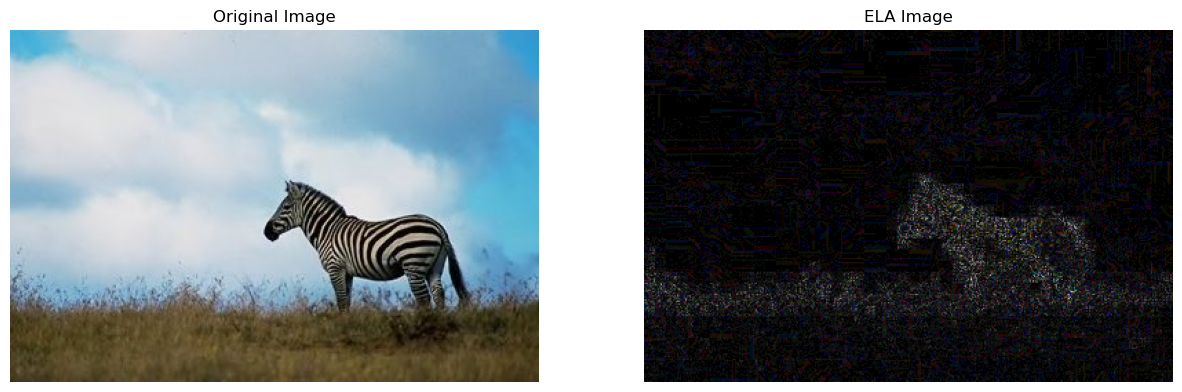

In [13]:
test_image_path = 'D:\project\image_forging\CASIA2.0_revised\Au\Au_ani_00001.jpg'   
test_image = prepare_image(test_image_path)
# print(test_image.shape)
test_image = test_image.reshape(-1, 128, 128, 3)

y_pred = model.predict(test_image)
y_pred_class = round(y_pred[0][0])

fig, ax = plt.subplots(1,2,figsize=(15,5)) 


original_image = plt.imread(test_image_path) 
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')


ax[1].axis('off')
ax[1].imshow(convert_to_ela_image(test_image_path,90)) 
ax[1].set_title('ELA Image')

print(f'Prediction: {class_names[y_pred_class]}')
if y_pred[0][0]<=0.5:
    print(f'Confidence:  {(1-(y_pred[0][0])) * 100:0.2f}%')
else:
    print(f'Confidence: {(y_pred[0][0]) * 100:0.2f}%')
print('--------------------------------------------------------------------------------------------------------------')

In [18]:
test_folder_path = 'D:\\project\\image_forging\\real' 
authentic, forged, total = 0, 0, 0

from tqdm import tqdm 
import os
import numpy as np  

for filename in tqdm(os.listdir(test_folder_path), desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        test_image_path = os.path.join(test_folder_path, filename)
        test_image = prepare_image(test_image_path)  
        test_image = test_image.reshape(-1, 128, 128, 3)
        
        y_pred = model.predict(test_image)
        y_pred_class = np.round(y_pred[0][0])
        
        total += 1
        if y_pred_class == 0:
            forged += 1
        else:
            authentic += 1

print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')


Processing Images :   0%|                                                                       | 0/56 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   2%|█▏                                                             | 1/56 [00:00<00:37,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   4%|██▎                                                            | 2/56 [00:01<00:47,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   5%|███▍                                                           | 3/56 [00:02<00:40,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   7%|████▌                                                          | 4/56 [00:03<00:42,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :   9%|█████▋                                                         | 5/56 [00:04<00:42,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  11%|██████▊                                                        | 6/56 [00:05<00:45,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  12%|███████▉                                                       | 7/56 [00:05<00:43,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  14%|█████████                                                      | 8/56 [00:06<00:42,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  16%|██████████▏                                                    | 9/56 [00:07<00:39,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  18%|███████████                                                   | 10/56 [00:08<00:40,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  20%|████████████▏                                                 | 11/56 [00:09<00:41,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  21%|█████████████▎                                                | 12/56 [00:10<00:43,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Images :  23%|██████████████▍                                               | 13/56 [00:11<00:41,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images :  25%|███████████████▌                                              | 14/56 [00:12<00:38,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images :  27%|████████████████▌                                             | 15/56 [00:13<00:34,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  29%|█████████████████▋                                            | 16/56 [00:13<00:31,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  30%|██████████████████▊                                           | 17/56 [00:14<00:33,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :  32%|███████████████████▉                                          | 18/56 [00:15<00:30,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images :  34%|█████████████████████                                         | 19/56 [00:16<00:31,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  36%|██████████████████████▏                                       | 20/56 [00:17<00:32,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  38%|███████████████████████▎                                      | 21/56 [00:18<00:32,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images :  39%|████████████████████████▎                                     | 22/56 [00:19<00:31,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  41%|█████████████████████████▍                                    | 23/56 [00:20<00:31,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  43%|██████████████████████████▌                                   | 24/56 [00:21<00:27,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images :  45%|███████████████████████████▋                                  | 25/56 [00:21<00:27,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :  46%|████████████████████████████▊                                 | 26/56 [00:22<00:24,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images :  48%|█████████████████████████████▉                                | 27/56 [00:23<00:24,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  50%|███████████████████████████████                               | 28/56 [00:24<00:25,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images :  52%|████████████████████████████████                              | 29/56 [00:25<00:24,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  54%|█████████████████████████████████▏                            | 30/56 [00:26<00:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  55%|██████████████████████████████████▎                           | 31/56 [00:26<00:20,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  57%|███████████████████████████████████▍                          | 32/56 [00:27<00:17,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  59%|████████████████████████████████████▌                         | 33/56 [00:28<00:15,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  61%|█████████████████████████████████████▋                        | 34/56 [00:28<00:15,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  62%|██████████████████████████████████████▊                       | 35/56 [00:29<00:14,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  64%|███████████████████████████████████████▊                      | 36/56 [00:30<00:15,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  66%|████████████████████████████████████████▉                     | 37/56 [00:31<00:13,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  68%|██████████████████████████████████████████                    | 38/56 [00:31<00:13,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  70%|███████████████████████████████████████████▏                  | 39/56 [00:32<00:13,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  71%|████████████████████████████████████████████▎                 | 40/56 [00:33<00:13,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  73%|█████████████████████████████████████████████▍                | 41/56 [00:34<00:12,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  75%|██████████████████████████████████████████████▌               | 42/56 [00:35<00:11,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  77%|███████████████████████████████████████████████▌              | 43/56 [00:36<00:11,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  79%|████████████████████████████████████████████████▋             | 44/56 [00:37<00:10,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  80%|█████████████████████████████████████████████████▊            | 45/56 [00:37<00:09,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  82%|██████████████████████████████████████████████████▉           | 46/56 [00:38<00:07,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  84%|████████████████████████████████████████████████████          | 47/56 [00:39<00:06,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images :  86%|█████████████████████████████████████████████████████▏        | 48/56 [00:39<00:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  88%|██████████████████████████████████████████████████████▎       | 49/56 [00:40<00:04,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  89%|███████████████████████████████████████████████████████▎      | 50/56 [00:41<00:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  91%|████████████████████████████████████████████████████████▍     | 51/56 [00:42<00:03,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  93%|█████████████████████████████████████████████████████████▌    | 52/56 [00:42<00:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Images :  95%|██████████████████████████████████████████████████████████▋   | 53/56 [00:43<00:02,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  96%|███████████████████████████████████████████████████████████▊  | 54/56 [00:44<00:01,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  98%|████████████████████████████████████████████████████████████▉ | 55/56 [00:45<00:00,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images : 100%|██████████████████████████████████████████████████████████████| 56/56 [00:45<00:00,  1.22it/s]

Total images: 56
Authentic Images: 56
Forged Images: 0


In [19]:
print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')

Total images: 56
Authentic Images: 56
Forged Images: 0


In [21]:
test_folder_path = 'D:\\project\\image_forging\\fake' 
authentic, forged, total = 0, 0, 0

from tqdm import tqdm 
import os
import numpy as np  

for filename in tqdm(os.listdir(test_folder_path), desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        test_image_path = os.path.join(test_folder_path, filename)
        test_image = prepare_image(test_image_path)  
        test_image = test_image.reshape(-1, 128, 128, 3)
        
        y_pred = model.predict(test_image)
        y_pred_class = np.round(y_pred[0][1])
        
        total += 1
        if y_pred_class == 0:
            forged += 1
        else:
            authentic += 1

print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')


Processing Images :   0%|                                                                      | 0/224 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   0%|▎                                                             | 1/224 [00:00<02:39,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   1%|▌                                                             | 2/224 [00:01<02:11,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   1%|▊                                                             | 3/224 [00:01<02:01,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :   2%|█                                                             | 4/224 [00:02<01:58,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :   2%|█▍                                                            | 5/224 [00:02<01:54,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   3%|█▋                                                            | 6/224 [00:03<02:16,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   3%|█▉                                                            | 7/224 [00:04<02:25,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   4%|██▏                                                           | 8/224 [00:05<02:31,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :   4%|██▍                                                           | 9/224 [00:05<02:36,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   4%|██▋                                                          | 10/224 [00:06<02:36,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   5%|██▉                                                          | 11/224 [00:07<02:16,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   5%|███▎                                                         | 12/224 [00:07<02:29,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images :   6%|███▌                                                         | 13/224 [00:08<02:34,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Images :   6%|███▊                                                         | 14/224 [00:09<02:40,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :   7%|████                                                         | 15/224 [00:10<02:56,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :   7%|████▎                                                        | 16/224 [00:11<02:59,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :   8%|████▋                                                        | 17/224 [00:12<02:54,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images :   8%|████▉                                                        | 18/224 [00:13<02:57,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :   8%|█████▏                                                       | 19/224 [00:13<02:35,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :   9%|█████▍                                                       | 20/224 [00:14<02:19,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :   9%|█████▋                                                       | 21/224 [00:14<02:06,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  10%|█████▉                                                       | 22/224 [00:15<01:55,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  10%|██████▎                                                      | 23/224 [00:15<01:52,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  11%|██████▌                                                      | 24/224 [00:16<02:02,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  11%|██████▊                                                      | 25/224 [00:17<02:12,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  12%|███████                                                      | 26/224 [00:17<02:16,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  12%|███████▎                                                     | 27/224 [00:18<02:18,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  12%|███████▋                                                     | 28/224 [00:19<02:04,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  13%|███████▉                                                     | 29/224 [00:19<01:53,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  13%|████████▏                                                    | 30/224 [00:20<01:47,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images :  14%|████████▍                                                    | 31/224 [00:20<01:42,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  14%|████████▋                                                    | 32/224 [00:21<01:41,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  15%|████████▉                                                    | 33/224 [00:21<01:39,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  15%|█████████▎                                                   | 34/224 [00:22<01:38,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  16%|█████████▌                                                   | 35/224 [00:22<01:38,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  16%|█████████▊                                                   | 36/224 [00:23<01:36,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  17%|██████████                                                   | 37/224 [00:23<01:45,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images :  17%|██████████▎                                                  | 38/224 [00:24<01:52,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  17%|██████████▌                                                  | 39/224 [00:25<01:55,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  18%|██████████▉                                                  | 40/224 [00:25<01:59,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  18%|███████████▏                                                 | 41/224 [00:26<01:52,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  19%|███████████▍                                                 | 42/224 [00:27<01:48,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  19%|███████████▋                                                 | 43/224 [00:27<01:45,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  20%|███████████▉                                                 | 44/224 [00:28<01:54,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  20%|████████████▎                                                | 45/224 [00:28<01:48,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  21%|████████████▌                                                | 46/224 [00:29<01:58,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  21%|████████████▊                                                | 47/224 [00:30<02:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  21%|█████████████                                                | 48/224 [00:31<02:04,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  22%|█████████████▎                                               | 49/224 [00:31<02:06,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  22%|█████████████▌                                               | 50/224 [00:32<01:53,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  23%|█████████████▉                                               | 51/224 [00:32<01:45,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  23%|██████████████▏                                              | 52/224 [00:33<01:40,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  24%|██████████████▍                                              | 53/224 [00:33<01:36,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  24%|██████████████▋                                              | 54/224 [00:34<01:41,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  25%|██████████████▉                                              | 55/224 [00:35<01:47,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  25%|███████████████▎                                             | 56/224 [00:36<01:49,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images :  25%|███████████████▌                                             | 57/224 [00:36<01:49,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  26%|███████████████▊                                             | 58/224 [00:37<01:50,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  26%|████████████████                                             | 59/224 [00:38<01:52,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  27%|████████████████▎                                            | 60/224 [00:38<01:59,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  27%|████████████████▌                                            | 61/224 [00:39<02:00,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images :  28%|████████████████▉                                            | 62/224 [00:40<02:04,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images :  28%|█████████████████▏                                           | 63/224 [00:41<02:01,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images :  29%|█████████████████▍                                           | 64/224 [00:42<02:01,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Images :  29%|█████████████████▋                                           | 65/224 [00:42<02:05,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images :  29%|█████████████████▉                                           | 66/224 [00:43<02:07,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  30%|██████████████████▏                                          | 67/224 [00:44<02:05,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images :  30%|██████████████████▌                                          | 68/224 [00:45<02:02,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images :  31%|██████████████████▊                                          | 69/224 [00:46<02:00,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  31%|███████████████████                                          | 70/224 [00:46<01:58,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  32%|███████████████████▎                                         | 71/224 [00:47<01:55,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images :  32%|███████████████████▌                                         | 72/224 [00:48<01:54,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images :  33%|███████████████████▉                                         | 73/224 [00:48<01:52,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  33%|████████████████████▏                                        | 74/224 [00:49<01:48,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  33%|████████████████████▍                                        | 75/224 [00:50<01:47,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  34%|████████████████████▋                                        | 76/224 [00:51<01:45,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  34%|████████████████████▉                                        | 77/224 [00:51<01:45,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  35%|█████████████████████▏                                       | 78/224 [00:52<01:48,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  35%|█████████████████████▌                                       | 79/224 [00:53<01:47,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  36%|█████████████████████▊                                       | 80/224 [00:54<01:46,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  36%|██████████████████████                                       | 81/224 [00:54<01:41,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  37%|██████████████████████▎                                      | 82/224 [00:55<01:40,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  37%|██████████████████████▌                                      | 83/224 [00:56<01:40,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  38%|██████████████████████▉                                      | 84/224 [00:56<01:37,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  38%|███████████████████████▏                                     | 85/224 [00:57<01:36,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  38%|███████████████████████▍                                     | 86/224 [00:58<01:36,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  39%|███████████████████████▋                                     | 87/224 [00:58<01:35,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  39%|███████████████████████▉                                     | 88/224 [00:59<01:36,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  40%|████████████████████████▏                                    | 89/224 [01:00<01:33,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  40%|████████████████████████▌                                    | 90/224 [01:00<01:22,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  41%|████████████████████████▊                                    | 91/224 [01:01<01:18,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  41%|█████████████████████████                                    | 92/224 [01:01<01:11,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  42%|█████████████████████████▎                                   | 93/224 [01:02<01:07,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  42%|█████████████████████████▌                                   | 94/224 [01:02<01:06,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  42%|█████████████████████████▊                                   | 95/224 [01:03<01:06,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  43%|██████████████████████████▏                                  | 96/224 [01:03<01:05,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  43%|██████████████████████████▍                                  | 97/224 [01:04<01:05,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images :  44%|██████████████████████████▋                                  | 98/224 [01:04<01:06,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  44%|██████████████████████████▉                                  | 99/224 [01:05<01:11,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  45%|██████████████████████████▊                                 | 100/224 [01:05<01:10,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  45%|███████████████████████████                                 | 101/224 [01:06<01:07,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  46%|███████████████████████████▎                                | 102/224 [01:07<01:06,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  46%|███████████████████████████▌                                | 103/224 [01:07<01:12,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  46%|███████████████████████████▊                                | 104/224 [01:08<01:15,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images :  47%|████████████████████████████▏                               | 105/224 [01:09<01:18,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  47%|████████████████████████████▍                               | 106/224 [01:09<01:19,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  48%|████████████████████████████▋                               | 107/224 [01:10<01:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  48%|████████████████████████████▉                               | 108/224 [01:11<01:24,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  49%|█████████████████████████████▏                              | 109/224 [01:12<01:25,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  49%|█████████████████████████████▍                              | 110/224 [01:12<01:23,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  50%|█████████████████████████████▋                              | 111/224 [01:13<01:15,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  50%|██████████████████████████████                              | 112/224 [01:14<01:21,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  50%|██████████████████████████████▎                             | 113/224 [01:14<01:19,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  51%|██████████████████████████████▌                             | 114/224 [01:15<01:21,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images :  51%|██████████████████████████████▊                             | 115/224 [01:16<01:19,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  52%|███████████████████████████████                             | 116/224 [01:17<01:19,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images :  52%|███████████████████████████████▎                            | 117/224 [01:17<01:14,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  53%|███████████████████████████████▌                            | 118/224 [01:18<01:09,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  53%|███████████████████████████████▉                            | 119/224 [01:18<01:04,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  54%|████████████████████████████████▏                           | 120/224 [01:19<01:00,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  54%|████████████████████████████████▍                           | 121/224 [01:20<01:03,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Images :  54%|████████████████████████████████▋                           | 122/224 [01:20<01:07,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  55%|████████████████████████████████▉                           | 123/224 [01:21<01:10,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images :  55%|█████████████████████████████████▏                          | 124/224 [01:22<01:13,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  56%|█████████████████████████████████▍                          | 125/224 [01:23<01:11,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  56%|█████████████████████████████████▊                          | 126/224 [01:23<01:12,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  57%|██████████████████████████████████                          | 127/224 [01:24<01:11,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  57%|██████████████████████████████████▎                         | 128/224 [01:25<01:11,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  58%|██████████████████████████████████▌                         | 129/224 [01:26<01:09,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  58%|██████████████████████████████████▊                         | 130/224 [01:26<01:07,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  58%|███████████████████████████████████                         | 131/224 [01:27<01:05,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  59%|███████████████████████████████████▎                        | 132/224 [01:28<01:03,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  59%|███████████████████████████████████▋                        | 133/224 [01:28<01:05,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  60%|███████████████████████████████████▉                        | 134/224 [01:29<01:04,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  60%|████████████████████████████████████▏                       | 135/224 [01:30<01:04,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  61%|████████████████████████████████████▍                       | 136/224 [01:31<01:02,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  61%|████████████████████████████████████▋                       | 137/224 [01:31<01:02,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  62%|████████████████████████████████████▉                       | 138/224 [01:32<01:01,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  62%|█████████████████████████████████████▏                      | 139/224 [01:33<01:01,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  62%|█████████████████████████████████████▌                      | 140/224 [01:34<01:02,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  63%|█████████████████████████████████████▊                      | 141/224 [01:34<01:03,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Images :  63%|██████████████████████████████████████                      | 142/224 [01:35<01:02,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images :  64%|██████████████████████████████████████▎                     | 143/224 [01:36<01:02,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Images :  64%|██████████████████████████████████████▌                     | 144/224 [01:37<01:02,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  65%|██████████████████████████████████████▊                     | 145/224 [01:37<01:01,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  65%|███████████████████████████████████████                     | 146/224 [01:38<00:58,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  66%|███████████████████████████████████████▍                    | 147/224 [01:39<00:52,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images :  66%|███████████████████████████████████████▋                    | 148/224 [01:39<00:53,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Images :  67%|███████████████████████████████████████▉                    | 149/224 [01:40<00:54,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images :  67%|████████████████████████████████████████▏                   | 150/224 [01:41<00:55,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images :  67%|████████████████████████████████████████▍                   | 151/224 [01:42<00:51,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  68%|████████████████████████████████████████▋                   | 152/224 [01:42<00:46,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images :  68%|████████████████████████████████████████▉                   | 153/224 [01:43<00:43,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images :  69%|█████████████████████████████████████████▎                  | 154/224 [01:43<00:41,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images :  69%|█████████████████████████████████████████▌                  | 155/224 [01:44<00:45,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  70%|█████████████████████████████████████████▊                  | 156/224 [01:45<00:46,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  70%|██████████████████████████████████████████                  | 157/224 [01:46<00:47,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  71%|██████████████████████████████████████████▎                 | 158/224 [01:46<00:42,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  71%|██████████████████████████████████████████▌                 | 159/224 [01:47<00:44,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  71%|██████████████████████████████████████████▊                 | 160/224 [01:47<00:44,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  72%|███████████████████████████████████████████▏                | 161/224 [01:48<00:44,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  72%|███████████████████████████████████████████▍                | 162/224 [01:49<00:43,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  73%|███████████████████████████████████████████▋                | 163/224 [01:50<00:43,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  73%|███████████████████████████████████████████▉                | 164/224 [01:50<00:44,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  74%|████████████████████████████████████████████▏               | 165/224 [01:51<00:43,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  74%|████████████████████████████████████████████▍               | 166/224 [01:52<00:43,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images :  75%|████████████████████████████████████████████▋               | 167/224 [01:53<00:43,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  75%|█████████████████████████████████████████████               | 168/224 [01:54<00:42,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  75%|█████████████████████████████████████████████▎              | 169/224 [01:54<00:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  76%|█████████████████████████████████████████████▌              | 170/224 [01:55<00:38,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  76%|█████████████████████████████████████████████▊              | 171/224 [01:56<00:37,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  77%|██████████████████████████████████████████████              | 172/224 [01:56<00:37,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  77%|██████████████████████████████████████████████▎             | 173/224 [01:57<00:33,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  78%|██████████████████████████████████████████████▌             | 174/224 [01:57<00:30,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  78%|██████████████████████████████████████████████▉             | 175/224 [01:58<00:29,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  79%|███████████████████████████████████████████████▏            | 176/224 [01:58<00:27,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  79%|███████████████████████████████████████████████▍            | 177/224 [01:59<00:26,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  79%|███████████████████████████████████████████████▋            | 178/224 [01:59<00:25,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  80%|███████████████████████████████████████████████▉            | 179/224 [02:00<00:24,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  80%|████████████████████████████████████████████████▏           | 180/224 [02:01<00:26,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images :  81%|████████████████████████████████████████████████▍           | 181/224 [02:01<00:25,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  81%|████████████████████████████████████████████████▊           | 182/224 [02:02<00:24,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  82%|█████████████████████████████████████████████████           | 183/224 [02:02<00:23,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  82%|█████████████████████████████████████████████████▎          | 184/224 [02:03<00:22,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  83%|█████████████████████████████████████████████████▌          | 185/224 [02:03<00:21,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  83%|█████████████████████████████████████████████████▊          | 186/224 [02:04<00:24,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  83%|██████████████████████████████████████████████████          | 187/224 [02:05<00:24,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images :  84%|██████████████████████████████████████████████████▎         | 188/224 [02:06<00:26,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  84%|██████████████████████████████████████████████████▋         | 189/224 [02:07<00:26,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  85%|██████████████████████████████████████████████████▉         | 190/224 [02:07<00:22,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  85%|███████████████████████████████████████████████████▏        | 191/224 [02:08<00:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  86%|███████████████████████████████████████████████████▍        | 192/224 [02:08<00:20,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  86%|███████████████████████████████████████████████████▋        | 193/224 [02:09<00:18,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  87%|███████████████████████████████████████████████████▉        | 194/224 [02:09<00:16,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  87%|████████████████████████████████████████████████████▏       | 195/224 [02:10<00:17,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  88%|████████████████████████████████████████████████████▌       | 196/224 [02:11<00:18,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  88%|████████████████████████████████████████████████████▊       | 197/224 [02:12<00:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  88%|█████████████████████████████████████████████████████       | 198/224 [02:12<00:18,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  89%|█████████████████████████████████████████████████████▎      | 199/224 [02:13<00:17,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  89%|█████████████████████████████████████████████████████▌      | 200/224 [02:14<00:18,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  90%|█████████████████████████████████████████████████████▊      | 201/224 [02:15<00:16,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  90%|██████████████████████████████████████████████████████      | 202/224 [02:15<00:15,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images :  91%|██████████████████████████████████████████████████████▍     | 203/224 [02:16<00:15,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  91%|██████████████████████████████████████████████████████▋     | 204/224 [02:17<00:14,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  92%|██████████████████████████████████████████████████████▉     | 205/224 [02:18<00:14,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images :  92%|███████████████████████████████████████████████████████▏    | 206/224 [02:18<00:13,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  92%|███████████████████████████████████████████████████████▍    | 207/224 [02:19<00:13,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images :  93%|███████████████████████████████████████████████████████▋    | 208/224 [02:20<00:12,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images :  93%|███████████████████████████████████████████████████████▉    | 209/224 [02:21<00:12,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Images :  94%|████████████████████████████████████████████████████████▎   | 210/224 [02:22<00:11,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  94%|████████████████████████████████████████████████████████▌   | 211/224 [02:23<00:10,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  95%|████████████████████████████████████████████████████████▊   | 212/224 [02:23<00:09,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  95%|█████████████████████████████████████████████████████████   | 213/224 [02:24<00:08,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  96%|█████████████████████████████████████████████████████████▎  | 214/224 [02:25<00:07,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  96%|█████████████████████████████████████████████████████████▌  | 215/224 [02:26<00:06,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images :  96%|█████████████████████████████████████████████████████████▊  | 216/224 [02:26<00:06,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  97%|██████████████████████████████████████████████████████████▏ | 217/224 [02:27<00:04,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  97%|██████████████████████████████████████████████████████████▍ | 218/224 [02:27<00:03,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  98%|██████████████████████████████████████████████████████████▋ | 219/224 [02:28<00:03,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  98%|██████████████████████████████████████████████████████████▉ | 220/224 [02:29<00:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images :  99%|███████████████████████████████████████████████████████████▏| 221/224 [02:29<00:01,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images :  99%|███████████████████████████████████████████████████████████▍| 222/224 [02:30<00:01,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images : 100%|███████████████████████████████████████████████████████████▋| 223/224 [02:31<00:00,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images : 100%|████████████████████████████████████████████████████████████| 224/224 [02:31<00:00,  1.48it/s]

Total images: 224
Authentic Images: 5
Forged Images: 219
